In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from nltk.corpus import stopwords
import string
import re
import torch.nn.functional as F
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import  os
from sklearn.preprocessing import LabelEncoder


In [2]:
is_cuda = torch.cuda.is_available()
if is_cuda == True:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Our Device =====>>>>>>", device)
df = pd.read_csv( '/kaggle/input/IMDB Dataset.csv')
df.head()

Our Device =====>>>>>> cpu


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


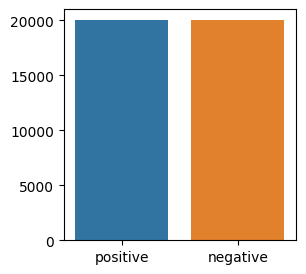

In [3]:
X = df['review'].values # Converts it into numpy array
y = df['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify = y) #stratify = y ===>positive and negative ratio of train and test data will be equal

totalcount = pd.Series(y_train).value_counts()
plt.figure(figsize=(3, 3))
sns.barplot(x = np.array(['positive', 'negative']), y= totalcount.values)
plt.show()

In [4]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []
  
    stop_words = set(stopwords.words('english'))
    for sentence in x_train:
        for word in sentence.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus_counter = Counter(word_list)
    corpus = sorted(corpus_counter, key=corpus_counter.get, reverse = True)[:1000]
    one_hot_vec_dic = {}
    for i, corp in enumerate(corpus):
        one_hot_vec_dic[corp] = i + 1
    final_x_train = []
    final_x_val = []
    
    for sentence in x_train:
        sentence_tokens = [] 
        for word in sentence.lower().split(): 
            ppword = preprocess_string(word)
            if ppword in one_hot_vec_dic.keys():
                sentence_tokens.append(one_hot_vec_dic[ppword])
        final_x_train.append(sentence_tokens)
  

    for sentence in x_val:
        sentence_tokens = [] 
        for word in sentence.lower().split(): 
            ppword = preprocess_string(word)
            if ppword in one_hot_vec_dic.keys():
                sentence_tokens.append(one_hot_vec_dic[ppword])
        final_x_val.append(sentence_tokens)  
       
    le = LabelEncoder()
    encode_train = le.fit_transform(y_train)
    encode_val = le.fit_transform(y_val)
    return final_x_train,final_x_val, encode_train, encode_val, one_hot_vec_dic
    

            
        
st = ['World is beautiful. beautiful beautiful beautiful USA is the best beautiful . I will go to USA only.']

labels = ['positive', 'negative', 'positive', 'negative', 'positive']

tockenize(st,labels,st,labels)       

X_train, X_test, Y_train, Y_test, vocab = tockenize(x_train, y_train, x_test, y_test)

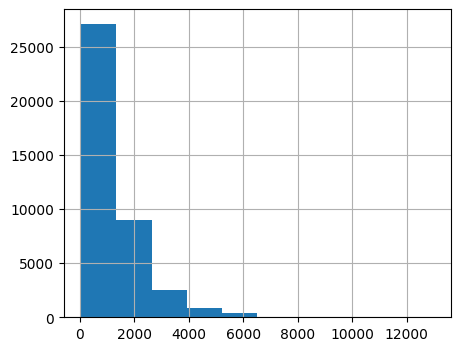

In [5]:
length_x_train = []
for i in x_train:
    length_x_train.append(len(i))

plt.figure(figsize=(5, 4)) 
pd.Series(length_x_train).hist()
plt.show()

In [6]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [7]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(X_train,500)
x_test_pad = padding_(X_test,500)

In [8]:
# create Tensor datasets
print(x_train_pad.dtype)
print(Y_train.dtype)

train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(Y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(Y_test))

# dataloaders
batch_size = 128

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,  drop_last = True)

int64
int64


In [9]:
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, output_dim, hidden_dim, embedding_dim,drop_prob=0.5):
        super(SentimentRNN, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim )
        self.rnn = nn.RNN(input_size = embedding_dim, hidden_size = self.hidden_dim, num_layers = no_layers, batch_first = True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)
        self.sig = nn.Sigmoid()
       



# batch_size = 5
# seq_length = 10
# hidden_dim = 20
# num_layers = 1

# rnn_out, hidden = self.rnn(embedding_layer, hidden)
# Then:

# rnn_out.shape → (5, 10, 20) (all hidden states for all words)
# hidden.shape → (1, 5, 20) (final hidden state for each sequence)
# rnn_out[:, -1, :] → (5, 20) (last word's output)
# hidden.squeeze(0) → (5, 20) (last hidden state)

    def forward(self,x,hidden):
        batch_size = x.size(0)
        print('=====>>>', batch_size)
        embeding_layer = self.embedding(x)
        rnn_out, hidden = self.rnn(embeding_layer, hidden)
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim) 
        out = self.dropout(rnn_out)
        out = self.fc(out)
        sig_out = self.sig(out)  
        batch_size = x.size(0)
        sig_out = sig_out.view(batch_size, -1) 
        sig_out = sig_out[:, -1] 
        return sig_out, hidden


    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        return (h0,c0)
        
        

In [10]:
no_layers = 2
vocab_size = len(vocab) + 1 
embedding_dim = 64
output_dim = 1
hidden_dim = 256
model = SentimentRNN(no_layers,vocab_size,output_dim, hidden_dim, embedding_dim,drop_prob=0.5)
model.to(device)
print(model)


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (rnn): RNN(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [11]:
lr = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [12]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    print('test')
    train_acc = 0.0
    model.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        h, c = model.init_hidden(batch_size)
        output,h = model(inputs,h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.detach().item())
        accuracy = acc(output.detach(),labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            # val_h, val_c = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            val_h, val_c = model.init_hidden(batch_size)
        
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy


    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
        

test


  0%|          | 0/312 [00:00<?, ?it/s]

=====>>> 128


  0%|          | 1/312 [00:10<55:12, 10.65s/it]

=====>>> 128


  1%|          | 2/312 [00:20<52:01, 10.07s/it]

=====>>> 128


  1%|          | 3/312 [00:29<50:18,  9.77s/it]

=====>>> 128


  1%|▏         | 4/312 [00:39<49:46,  9.70s/it]

=====>>> 128


  2%|▏         | 5/312 [00:48<49:26,  9.66s/it]

=====>>> 128


  2%|▏         | 6/312 [00:58<48:58,  9.60s/it]

=====>>> 128


  2%|▏         | 7/312 [01:07<48:28,  9.54s/it]

=====>>> 128


  3%|▎         | 8/312 [01:17<48:46,  9.63s/it]

=====>>> 128


  3%|▎         | 9/312 [01:27<48:32,  9.61s/it]

=====>>> 128


  3%|▎         | 10/312 [01:36<48:17,  9.59s/it]

=====>>> 128


  4%|▎         | 11/312 [01:46<49:02,  9.77s/it]

=====>>> 128


  4%|▍         | 12/312 [01:56<48:44,  9.75s/it]

=====>>> 128


  4%|▍         | 13/312 [02:06<48:38,  9.76s/it]

=====>>> 128


  4%|▍         | 14/312 [02:16<48:34,  9.78s/it]

=====>>> 128


  5%|▍         | 15/312 [02:26<48:28,  9.79s/it]

=====>>> 128


  5%|▌         | 16/312 [02:35<47:55,  9.71s/it]

=====>>> 128


  5%|▌         | 17/312 [02:44<47:17,  9.62s/it]

=====>>> 128


  6%|▌         | 18/312 [02:54<46:53,  9.57s/it]

=====>>> 128


  6%|▌         | 19/312 [03:03<46:19,  9.49s/it]

=====>>> 128


  6%|▋         | 20/312 [03:13<46:22,  9.53s/it]

=====>>> 128


  7%|▋         | 21/312 [03:24<48:03,  9.91s/it]

=====>>> 128


  7%|▋         | 22/312 [03:35<50:11, 10.38s/it]

=====>>> 128


  7%|▋         | 23/312 [03:46<50:55, 10.57s/it]

=====>>> 128


  8%|▊         | 24/312 [03:57<50:46, 10.58s/it]

=====>>> 128


  8%|▊         | 25/312 [04:07<50:15, 10.51s/it]

=====>>> 128


  8%|▊         | 26/312 [04:17<49:45, 10.44s/it]

=====>>> 128


  9%|▊         | 27/312 [04:28<49:46, 10.48s/it]

=====>>> 128


  9%|▉         | 28/312 [04:39<49:52, 10.54s/it]

=====>>> 128


  9%|▉         | 29/312 [04:50<50:51, 10.78s/it]

=====>>> 128


 10%|▉         | 30/312 [05:03<53:13, 11.32s/it]

=====>>> 128


 10%|▉         | 31/312 [05:16<56:08, 11.99s/it]

=====>>> 128


 10%|█         | 32/312 [05:32<1:01:39, 13.21s/it]

=====>>> 128


 11%|█         | 33/312 [05:49<1:06:48, 14.37s/it]

=====>>> 128


 11%|█         | 34/312 [06:02<1:04:10, 13.85s/it]

=====>>> 128


 11%|█         | 35/312 [06:10<56:27, 12.23s/it]  

=====>>> 128


 12%|█▏        | 36/312 [06:18<49:56, 10.86s/it]

=====>>> 128


 12%|█▏        | 37/312 [06:29<49:44, 10.85s/it]

=====>>> 128


 12%|█▏        | 38/312 [06:40<49:22, 10.81s/it]

=====>>> 128


 12%|█▎        | 39/312 [06:48<46:37, 10.25s/it]

=====>>> 128


 13%|█▎        | 40/312 [06:57<44:04,  9.72s/it]

=====>>> 128


 13%|█▎        | 41/312 [07:06<42:19,  9.37s/it]

=====>>> 128


 13%|█▎        | 42/312 [07:14<40:32,  9.01s/it]

=====>>> 128


 14%|█▍        | 43/312 [07:22<39:09,  8.73s/it]

=====>>> 128


 14%|█▍        | 44/312 [07:30<38:02,  8.52s/it]

=====>>> 128


 14%|█▍        | 45/312 [07:38<37:34,  8.44s/it]

=====>>> 128


 15%|█▍        | 46/312 [07:46<36:31,  8.24s/it]

=====>>> 128


 15%|█▌        | 47/312 [07:54<35:59,  8.15s/it]

=====>>> 128


 15%|█▌        | 48/312 [08:02<35:41,  8.11s/it]

=====>>> 128


 16%|█▌        | 49/312 [08:10<36:04,  8.23s/it]

=====>>> 128


 16%|█▌        | 50/312 [08:18<35:52,  8.22s/it]

=====>>> 128


 16%|█▋        | 51/312 [08:27<35:43,  8.21s/it]

=====>>> 128


 17%|█▋        | 52/312 [08:35<35:53,  8.28s/it]

=====>>> 128


 17%|█▋        | 53/312 [08:44<36:01,  8.34s/it]

=====>>> 128


 17%|█▋        | 54/312 [08:52<36:02,  8.38s/it]

=====>>> 128


 18%|█▊        | 55/312 [09:00<35:45,  8.35s/it]

=====>>> 128


 18%|█▊        | 56/312 [09:09<35:50,  8.40s/it]

=====>>> 128


 18%|█▊        | 57/312 [09:18<36:29,  8.59s/it]

=====>>> 128


 19%|█▊        | 58/312 [09:27<36:39,  8.66s/it]

=====>>> 128


 19%|█▉        | 59/312 [09:36<36:47,  8.73s/it]

=====>>> 128


 19%|█▉        | 60/312 [09:45<37:21,  8.90s/it]

=====>>> 128


 20%|█▉        | 61/312 [09:54<37:17,  8.92s/it]

=====>>> 128


 20%|█▉        | 62/312 [10:04<38:15,  9.18s/it]

=====>>> 128


 20%|██        | 63/312 [10:15<40:29,  9.76s/it]

=====>>> 128


 21%|██        | 64/312 [10:27<43:55, 10.63s/it]

=====>>> 128


 21%|██        | 65/312 [10:34<38:52,  9.44s/it]

=====>>> 128


 21%|██        | 66/312 [10:41<35:14,  8.60s/it]

=====>>> 128


 21%|██▏       | 67/312 [10:48<32:58,  8.08s/it]

=====>>> 128


 22%|██▏       | 68/312 [10:54<31:14,  7.68s/it]

=====>>> 128


 22%|██▏       | 69/312 [11:01<30:12,  7.46s/it]

=====>>> 128


 22%|██▏       | 70/312 [11:12<33:47,  8.38s/it]

=====>>> 128


 23%|██▎       | 71/312 [11:24<37:45,  9.40s/it]

=====>>> 128


 23%|██▎       | 72/312 [11:35<40:02, 10.01s/it]

=====>>> 128


 23%|██▎       | 73/312 [11:45<39:47,  9.99s/it]

=====>>> 128


 24%|██▎       | 74/312 [11:52<36:24,  9.18s/it]

=====>>> 128


 24%|██▍       | 75/312 [11:59<33:40,  8.53s/it]

=====>>> 128


 24%|██▍       | 76/312 [12:06<31:45,  8.07s/it]

=====>>> 128


 25%|██▍       | 77/312 [12:13<30:12,  7.71s/it]

=====>>> 128


 25%|██▌       | 78/312 [12:20<29:10,  7.48s/it]

=====>>> 128


 25%|██▌       | 79/312 [12:30<32:09,  8.28s/it]

=====>>> 128


 26%|██▌       | 80/312 [12:41<35:16,  9.12s/it]

=====>>> 128


 26%|██▌       | 81/312 [12:53<37:44,  9.80s/it]

=====>>> 128


 26%|██▋       | 82/312 [13:04<39:36, 10.33s/it]

=====>>> 128


 27%|██▋       | 83/312 [13:16<41:13, 10.80s/it]

=====>>> 128


 27%|██▋       | 84/312 [13:29<42:52, 11.28s/it]

=====>>> 128


 27%|██▋       | 85/312 [13:40<42:52, 11.33s/it]

=====>>> 128


 28%|██▊       | 86/312 [13:51<42:10, 11.19s/it]

=====>>> 128


 28%|██▊       | 87/312 [13:57<36:26,  9.72s/it]

=====>>> 128


 28%|██▊       | 88/312 [14:01<29:44,  7.97s/it]

=====>>> 128


 29%|██▊       | 89/312 [14:12<32:59,  8.88s/it]

=====>>> 128


 29%|██▉       | 90/312 [14:20<32:08,  8.69s/it]

=====>>> 128


 29%|██▉       | 91/312 [14:28<30:38,  8.32s/it]

=====>>> 128


 29%|██▉       | 92/312 [14:35<29:23,  8.02s/it]

=====>>> 128


 30%|██▉       | 93/312 [14:42<28:15,  7.74s/it]

=====>>> 128


 30%|███       | 94/312 [14:49<27:28,  7.56s/it]

=====>>> 128


 30%|███       | 95/312 [14:56<26:51,  7.42s/it]

=====>>> 128


 31%|███       | 96/312 [15:04<26:38,  7.40s/it]

=====>>> 128


 31%|███       | 97/312 [15:11<26:10,  7.30s/it]

=====>>> 128


 31%|███▏      | 98/312 [15:18<25:43,  7.21s/it]

=====>>> 128


 32%|███▏      | 99/312 [15:25<25:24,  7.16s/it]

=====>>> 128


 32%|███▏      | 100/312 [15:32<24:57,  7.07s/it]

=====>>> 128


 32%|███▏      | 101/312 [15:39<25:03,  7.12s/it]

=====>>> 128


 33%|███▎      | 102/312 [15:46<24:46,  7.08s/it]

=====>>> 128


 33%|███▎      | 103/312 [15:53<24:36,  7.07s/it]

=====>>> 128


 33%|███▎      | 104/312 [16:00<24:23,  7.04s/it]

=====>>> 128


 34%|███▎      | 105/312 [16:07<24:35,  7.13s/it]

=====>>> 128


 34%|███▍      | 106/312 [16:14<24:18,  7.08s/it]

=====>>> 128


 34%|███▍      | 107/312 [16:21<24:01,  7.03s/it]

=====>>> 128


 35%|███▍      | 108/312 [16:28<23:55,  7.04s/it]

=====>>> 128


 35%|███▍      | 109/312 [16:35<23:42,  7.01s/it]

=====>>> 128


 35%|███▌      | 110/312 [16:42<23:41,  7.04s/it]

=====>>> 128


 36%|███▌      | 111/312 [16:49<23:28,  7.01s/it]

=====>>> 128


 36%|███▌      | 112/312 [16:56<23:20,  7.00s/it]

=====>>> 128


 36%|███▌      | 113/312 [17:03<23:21,  7.05s/it]

=====>>> 128


 37%|███▋      | 114/312 [17:11<24:06,  7.31s/it]

=====>>> 128


 37%|███▋      | 115/312 [17:19<24:31,  7.47s/it]

=====>>> 128


 37%|███▋      | 116/312 [17:28<25:49,  7.91s/it]

=====>>> 128


 38%|███▊      | 117/312 [17:36<25:17,  7.78s/it]

=====>>> 128


 38%|███▊      | 118/312 [17:43<24:39,  7.63s/it]

=====>>> 128


 38%|███▊      | 119/312 [17:50<23:56,  7.44s/it]

=====>>> 128


 38%|███▊      | 120/312 [17:57<23:21,  7.30s/it]

=====>>> 128


 39%|███▉      | 121/312 [18:04<22:52,  7.19s/it]

=====>>> 128


 39%|███▉      | 122/312 [18:11<22:37,  7.15s/it]

=====>>> 128


 39%|███▉      | 123/312 [18:18<22:53,  7.27s/it]

=====>>> 128


 40%|███▉      | 124/312 [18:26<22:55,  7.32s/it]

=====>>> 128


 40%|████      | 125/312 [18:33<23:04,  7.40s/it]

=====>>> 128


 40%|████      | 126/312 [18:41<22:58,  7.41s/it]

=====>>> 128


 41%|████      | 127/312 [18:49<23:08,  7.50s/it]

=====>>> 128


 41%|████      | 128/312 [18:56<22:47,  7.43s/it]

=====>>> 128


 41%|████▏     | 129/312 [19:03<22:23,  7.34s/it]

=====>>> 128


 42%|████▏     | 130/312 [19:10<22:00,  7.26s/it]

=====>>> 128


 42%|████▏     | 131/312 [19:17<21:55,  7.27s/it]

=====>>> 128


 42%|████▏     | 132/312 [19:24<21:31,  7.18s/it]

=====>>> 128


 43%|████▎     | 133/312 [19:31<21:13,  7.11s/it]

=====>>> 128


 43%|████▎     | 134/312 [19:38<21:07,  7.12s/it]

=====>>> 128


 43%|████▎     | 135/312 [19:45<21:01,  7.13s/it]

=====>>> 128


 44%|████▎     | 136/312 [19:53<21:04,  7.19s/it]

=====>>> 128


 44%|████▍     | 137/312 [20:00<21:06,  7.24s/it]

=====>>> 128


 44%|████▍     | 138/312 [20:08<21:11,  7.31s/it]

=====>>> 128


 45%|████▍     | 139/312 [20:15<21:13,  7.36s/it]

=====>>> 128


 45%|████▍     | 140/312 [20:23<21:27,  7.48s/it]

=====>>> 128


 45%|████▌     | 141/312 [20:30<21:21,  7.49s/it]

=====>>> 128


 46%|████▌     | 142/312 [20:38<21:01,  7.42s/it]

=====>>> 128


 46%|████▌     | 143/312 [20:45<20:37,  7.32s/it]

=====>>> 128


 46%|████▌     | 144/312 [20:52<20:17,  7.25s/it]

=====>>> 128


 46%|████▋     | 145/312 [20:59<20:11,  7.25s/it]

=====>>> 128


 47%|████▋     | 146/312 [21:06<19:56,  7.20s/it]

=====>>> 128


 47%|████▋     | 147/312 [21:13<19:33,  7.11s/it]

=====>>> 128


 47%|████▋     | 148/312 [21:20<19:13,  7.04s/it]

=====>>> 128


 48%|████▊     | 149/312 [21:27<18:58,  6.98s/it]

=====>>> 128


 48%|████▊     | 150/312 [21:33<18:20,  6.80s/it]

=====>>> 128


 48%|████▊     | 151/312 [21:39<17:43,  6.61s/it]

=====>>> 128


 49%|████▊     | 152/312 [21:45<17:10,  6.44s/it]

=====>>> 128


 49%|████▉     | 153/312 [21:51<16:45,  6.32s/it]

=====>>> 128


 49%|████▉     | 154/312 [21:58<16:45,  6.36s/it]

=====>>> 128


 50%|████▉     | 155/312 [22:04<16:22,  6.26s/it]

=====>>> 128


 50%|█████     | 156/312 [22:10<16:08,  6.21s/it]

=====>>> 128


 50%|█████     | 157/312 [22:16<15:55,  6.16s/it]

=====>>> 128


 51%|█████     | 158/312 [22:22<15:49,  6.17s/it]

=====>>> 128


 51%|█████     | 159/312 [22:29<16:02,  6.29s/it]

=====>>> 128


 51%|█████▏    | 160/312 [22:35<15:50,  6.26s/it]

=====>>> 128


 52%|█████▏    | 161/312 [22:41<15:34,  6.19s/it]

=====>>> 128


 52%|█████▏    | 162/312 [22:47<15:31,  6.21s/it]

=====>>> 128


 52%|█████▏    | 163/312 [22:53<15:24,  6.21s/it]

=====>>> 128


 53%|█████▎    | 164/312 [23:00<15:33,  6.31s/it]

=====>>> 128


 53%|█████▎    | 165/312 [23:06<15:24,  6.29s/it]

=====>>> 128


 53%|█████▎    | 166/312 [23:12<15:08,  6.22s/it]

=====>>> 128


 54%|█████▎    | 167/312 [23:18<14:45,  6.10s/it]

=====>>> 128


 54%|█████▍    | 168/312 [23:24<14:39,  6.11s/it]

=====>>> 128


 54%|█████▍    | 169/312 [23:30<14:33,  6.11s/it]

=====>>> 128


 54%|█████▍    | 170/312 [23:37<14:55,  6.31s/it]

=====>>> 128


 55%|█████▍    | 171/312 [23:44<14:56,  6.36s/it]

=====>>> 128


 55%|█████▌    | 172/312 [23:50<15:01,  6.44s/it]

=====>>> 128


 55%|█████▌    | 173/312 [23:57<15:01,  6.48s/it]

=====>>> 128


 56%|█████▌    | 174/312 [24:04<15:17,  6.65s/it]

=====>>> 128


 56%|█████▌    | 175/312 [24:11<15:20,  6.72s/it]

=====>>> 128


 56%|█████▋    | 176/312 [24:17<15:14,  6.72s/it]

=====>>> 128


 57%|█████▋    | 177/312 [24:24<14:57,  6.65s/it]

=====>>> 128


 57%|█████▋    | 178/312 [24:30<14:43,  6.59s/it]

=====>>> 128


 57%|█████▋    | 179/312 [24:37<14:52,  6.71s/it]

=====>>> 128


 58%|█████▊    | 180/312 [24:44<14:34,  6.62s/it]

=====>>> 128


 58%|█████▊    | 181/312 [24:51<14:33,  6.66s/it]

=====>>> 128


 58%|█████▊    | 182/312 [24:57<14:34,  6.72s/it]

=====>>> 128


 59%|█████▊    | 183/312 [25:05<14:47,  6.88s/it]

=====>>> 128


 59%|█████▉    | 184/312 [25:12<15:07,  7.09s/it]

=====>>> 128


 59%|█████▉    | 185/312 [25:20<15:17,  7.22s/it]

=====>>> 128


 60%|█████▉    | 186/312 [25:27<15:21,  7.31s/it]

=====>>> 128


 60%|█████▉    | 187/312 [25:35<15:24,  7.40s/it]

=====>>> 128


 60%|██████    | 188/312 [25:43<15:26,  7.47s/it]

=====>>> 128


 61%|██████    | 189/312 [25:50<15:14,  7.44s/it]

=====>>> 128


 61%|██████    | 190/312 [25:57<15:05,  7.42s/it]

=====>>> 128


 61%|██████    | 191/312 [26:05<14:54,  7.39s/it]

=====>>> 128


 62%|██████▏   | 192/312 [26:12<14:53,  7.44s/it]

=====>>> 128


 62%|██████▏   | 193/312 [26:19<14:36,  7.36s/it]

=====>>> 128


 62%|██████▏   | 194/312 [26:27<14:21,  7.30s/it]

=====>>> 128


 62%|██████▎   | 195/312 [26:34<14:05,  7.22s/it]

=====>>> 128


 63%|██████▎   | 196/312 [26:41<14:04,  7.28s/it]

=====>>> 128


 63%|██████▎   | 197/312 [26:49<14:23,  7.51s/it]

=====>>> 128


 63%|██████▎   | 198/312 [26:57<14:31,  7.65s/it]

=====>>> 128


 64%|██████▍   | 199/312 [27:05<14:28,  7.68s/it]

=====>>> 128


 64%|██████▍   | 200/312 [27:12<14:17,  7.66s/it]

=====>>> 128


 64%|██████▍   | 201/312 [27:20<14:05,  7.62s/it]

=====>>> 128


 65%|██████▍   | 202/312 [27:27<13:48,  7.53s/it]

=====>>> 128


 65%|██████▌   | 203/312 [27:34<13:32,  7.46s/it]

=====>>> 128


 65%|██████▌   | 204/312 [27:42<13:23,  7.44s/it]

=====>>> 128


 66%|██████▌   | 205/312 [27:50<13:22,  7.50s/it]

=====>>> 128


 66%|██████▌   | 206/312 [27:57<13:07,  7.42s/it]

=====>>> 128


 66%|██████▋   | 207/312 [28:04<12:56,  7.39s/it]

=====>>> 128


 67%|██████▋   | 208/312 [28:11<12:40,  7.31s/it]

=====>>> 128


 67%|██████▋   | 209/312 [28:18<12:27,  7.26s/it]

=====>>> 128


 67%|██████▋   | 210/312 [28:26<12:23,  7.28s/it]

=====>>> 128


 68%|██████▊   | 211/312 [28:33<12:28,  7.41s/it]

=====>>> 128


 68%|██████▊   | 212/312 [28:41<12:31,  7.52s/it]

=====>>> 128


 68%|██████▊   | 213/312 [28:49<12:23,  7.51s/it]

=====>>> 128


 69%|██████▊   | 214/312 [28:56<12:01,  7.36s/it]

=====>>> 128


 69%|██████▉   | 215/312 [29:02<11:24,  7.05s/it]

=====>>> 128


 69%|██████▉   | 216/312 [29:08<10:53,  6.81s/it]

=====>>> 128


 70%|██████▉   | 217/312 [29:14<10:28,  6.62s/it]

=====>>> 128


 70%|██████▉   | 218/312 [29:21<10:07,  6.46s/it]

=====>>> 128


 70%|███████   | 219/312 [29:27<09:51,  6.36s/it]

=====>>> 128


 71%|███████   | 220/312 [29:32<09:27,  6.17s/it]

=====>>> 128


 71%|███████   | 221/312 [29:38<09:04,  5.98s/it]

=====>>> 128


 71%|███████   | 222/312 [29:43<08:45,  5.83s/it]

=====>>> 128


 71%|███████▏  | 223/312 [29:49<08:27,  5.71s/it]

=====>>> 128


 72%|███████▏  | 224/312 [29:54<08:19,  5.68s/it]

=====>>> 128


 72%|███████▏  | 225/312 [30:00<08:13,  5.67s/it]

=====>>> 128


 72%|███████▏  | 226/312 [30:06<08:02,  5.62s/it]

=====>>> 128


 73%|███████▎  | 227/312 [30:11<07:53,  5.57s/it]

=====>>> 128


 73%|███████▎  | 228/312 [30:17<07:45,  5.54s/it]

=====>>> 128


 73%|███████▎  | 229/312 [30:22<07:37,  5.51s/it]

=====>>> 128


 74%|███████▎  | 230/312 [30:28<07:36,  5.57s/it]

=====>>> 128


 74%|███████▍  | 231/312 [30:33<07:27,  5.53s/it]

=====>>> 128


 74%|███████▍  | 232/312 [30:38<07:18,  5.48s/it]

=====>>> 128


 75%|███████▍  | 233/312 [30:44<07:10,  5.44s/it]

=====>>> 128


 75%|███████▌  | 234/312 [30:49<07:01,  5.41s/it]

=====>>> 128


 75%|███████▌  | 235/312 [30:54<06:54,  5.38s/it]

=====>>> 128


 76%|███████▌  | 236/312 [31:00<06:50,  5.40s/it]

=====>>> 128


 76%|███████▌  | 237/312 [31:05<06:43,  5.38s/it]

=====>>> 128


 76%|███████▋  | 238/312 [31:10<06:35,  5.35s/it]

=====>>> 128


 77%|███████▋  | 239/312 [31:16<06:29,  5.33s/it]

=====>>> 128


 77%|███████▋  | 240/312 [31:21<06:23,  5.32s/it]

=====>>> 128


 77%|███████▋  | 241/312 [31:26<06:19,  5.34s/it]

=====>>> 128


 78%|███████▊  | 242/312 [31:32<06:20,  5.43s/it]

=====>>> 128


 78%|███████▊  | 243/312 [31:38<06:14,  5.42s/it]

=====>>> 128


 78%|███████▊  | 244/312 [31:43<06:09,  5.44s/it]

=====>>> 128


 79%|███████▊  | 245/312 [31:48<06:04,  5.44s/it]

=====>>> 128


 79%|███████▉  | 246/312 [31:54<05:58,  5.43s/it]

=====>>> 128


 79%|███████▉  | 247/312 [31:59<05:52,  5.42s/it]

=====>>> 128


 79%|███████▉  | 248/312 [32:05<05:52,  5.51s/it]

=====>>> 128


 80%|███████▉  | 249/312 [32:10<05:45,  5.49s/it]

=====>>> 128


 80%|████████  | 250/312 [32:16<05:36,  5.42s/it]

=====>>> 128


 80%|████████  | 251/312 [32:21<05:29,  5.40s/it]

=====>>> 128


 81%|████████  | 252/312 [32:26<05:23,  5.39s/it]

=====>>> 128


 81%|████████  | 253/312 [32:32<05:19,  5.42s/it]

=====>>> 128


 81%|████████▏ | 254/312 [32:38<05:21,  5.55s/it]

=====>>> 128


 82%|████████▏ | 255/312 [32:43<05:16,  5.55s/it]

=====>>> 128


 82%|████████▏ | 256/312 [32:49<05:10,  5.55s/it]

=====>>> 128


 82%|████████▏ | 257/312 [32:54<05:04,  5.55s/it]

=====>>> 128


 83%|████████▎ | 258/312 [33:00<04:58,  5.52s/it]

=====>>> 128


 83%|████████▎ | 259/312 [33:06<04:57,  5.62s/it]

=====>>> 128


 83%|████████▎ | 260/312 [33:11<04:52,  5.63s/it]

=====>>> 128


 84%|████████▎ | 261/312 [33:17<04:47,  5.65s/it]

=====>>> 128


 84%|████████▍ | 262/312 [33:23<04:42,  5.65s/it]

=====>>> 128


 84%|████████▍ | 263/312 [33:28<04:35,  5.61s/it]

=====>>> 128


 85%|████████▍ | 264/312 [33:34<04:30,  5.63s/it]

=====>>> 128


 85%|████████▍ | 265/312 [33:39<04:24,  5.62s/it]

=====>>> 128


 85%|████████▌ | 266/312 [33:45<04:17,  5.61s/it]

=====>>> 128


 86%|████████▌ | 267/312 [33:51<04:11,  5.59s/it]

=====>>> 128


 86%|████████▌ | 268/312 [33:56<04:06,  5.59s/it]

=====>>> 128


 86%|████████▌ | 269/312 [34:02<04:04,  5.68s/it]

=====>>> 128


 87%|████████▋ | 270/312 [34:08<04:02,  5.76s/it]

=====>>> 128


 87%|████████▋ | 271/312 [34:14<04:04,  5.96s/it]

=====>>> 128


 87%|████████▋ | 272/312 [34:20<03:58,  5.95s/it]

=====>>> 128


 88%|████████▊ | 273/312 [34:26<03:52,  5.96s/it]

=====>>> 128


 88%|████████▊ | 274/312 [34:32<03:46,  5.97s/it]

=====>>> 128


 88%|████████▊ | 275/312 [34:38<03:40,  5.96s/it]

=====>>> 128


 88%|████████▊ | 276/312 [34:44<03:36,  6.02s/it]

=====>>> 128


 89%|████████▉ | 277/312 [34:50<03:30,  6.01s/it]

=====>>> 128


 89%|████████▉ | 278/312 [34:56<03:24,  6.01s/it]

=====>>> 128


 89%|████████▉ | 279/312 [35:02<03:17,  5.98s/it]

=====>>> 128


 90%|████████▉ | 280/312 [35:08<03:09,  5.93s/it]

=====>>> 128


 90%|█████████ | 281/312 [35:14<03:06,  6.01s/it]

=====>>> 128


 90%|█████████ | 282/312 [35:20<02:59,  5.98s/it]

=====>>> 128


 91%|█████████ | 283/312 [35:26<02:55,  6.05s/it]

=====>>> 128


 91%|█████████ | 284/312 [35:33<02:49,  6.06s/it]

=====>>> 128


 91%|█████████▏| 285/312 [35:39<02:45,  6.13s/it]

=====>>> 128


 92%|█████████▏| 286/312 [35:46<02:43,  6.30s/it]

=====>>> 128


 92%|█████████▏| 287/312 [35:52<02:38,  6.34s/it]

=====>>> 128


 92%|█████████▏| 288/312 [35:59<02:34,  6.43s/it]

=====>>> 128


 93%|█████████▎| 289/312 [36:05<02:27,  6.42s/it]

=====>>> 128


 93%|█████████▎| 290/312 [36:12<02:23,  6.51s/it]

=====>>> 128


 93%|█████████▎| 291/312 [36:18<02:16,  6.52s/it]

=====>>> 128


 94%|█████████▎| 292/312 [36:24<02:04,  6.25s/it]

=====>>> 128


 94%|█████████▍| 293/312 [36:30<01:55,  6.05s/it]

=====>>> 128


 94%|█████████▍| 294/312 [36:35<01:46,  5.90s/it]

=====>>> 128


 95%|█████████▍| 295/312 [36:41<01:38,  5.82s/it]

=====>>> 128


 95%|█████████▍| 296/312 [36:47<01:33,  5.83s/it]

=====>>> 128


 95%|█████████▌| 297/312 [36:53<01:30,  6.00s/it]

=====>>> 128


 96%|█████████▌| 298/312 [36:59<01:25,  6.10s/it]

=====>>> 128


 96%|█████████▌| 299/312 [37:06<01:21,  6.29s/it]

=====>>> 128


 96%|█████████▌| 300/312 [37:13<01:17,  6.46s/it]

=====>>> 128


 96%|█████████▋| 301/312 [37:20<01:13,  6.72s/it]

=====>>> 128


 97%|█████████▋| 302/312 [37:28<01:09,  6.94s/it]

=====>>> 128


 97%|█████████▋| 303/312 [37:35<01:02,  6.96s/it]

=====>>> 128


 97%|█████████▋| 304/312 [37:41<00:55,  6.89s/it]

=====>>> 128


 98%|█████████▊| 305/312 [37:48<00:47,  6.72s/it]

=====>>> 128


 98%|█████████▊| 306/312 [37:54<00:39,  6.62s/it]

=====>>> 128


 98%|█████████▊| 307/312 [38:00<00:32,  6.41s/it]

=====>>> 128


 99%|█████████▊| 308/312 [38:06<00:24,  6.18s/it]

=====>>> 128


 99%|█████████▉| 309/312 [38:11<00:18,  6.06s/it]

=====>>> 128


 99%|█████████▉| 310/312 [38:17<00:11,  5.98s/it]

=====>>> 128


100%|█████████▉| 311/312 [38:23<00:06,  6.06s/it]

=====>>> 128


100%|██████████| 312/312 [38:30<00:00,  7.40s/it]


=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128

  0%|          | 0/312 [00:00<?, ?it/s]

=====>>> 128


  0%|          | 1/312 [00:06<31:57,  6.17s/it]

=====>>> 128


  1%|          | 2/312 [00:12<32:02,  6.20s/it]

=====>>> 128


  1%|          | 3/312 [00:18<32:38,  6.34s/it]

=====>>> 128


  1%|▏         | 4/312 [00:25<32:42,  6.37s/it]

=====>>> 128


  2%|▏         | 5/312 [00:31<32:53,  6.43s/it]

=====>>> 128


  2%|▏         | 6/312 [00:38<33:06,  6.49s/it]

=====>>> 128


  2%|▏         | 7/312 [00:45<33:31,  6.59s/it]

=====>>> 128


  3%|▎         | 8/312 [00:52<34:36,  6.83s/it]

=====>>> 128


  3%|▎         | 9/312 [00:59<35:01,  6.94s/it]

=====>>> 128


  3%|▎         | 10/312 [01:06<35:14,  7.00s/it]

=====>>> 128


  4%|▎         | 11/312 [01:14<35:20,  7.04s/it]

=====>>> 128


  4%|▍         | 12/312 [01:21<35:17,  7.06s/it]

=====>>> 128


  4%|▍         | 13/312 [01:27<34:15,  6.87s/it]

=====>>> 128


  4%|▍         | 14/312 [01:33<32:48,  6.61s/it]

=====>>> 128


  5%|▍         | 15/312 [01:39<31:29,  6.36s/it]

=====>>> 128


  5%|▌         | 16/312 [01:45<30:25,  6.17s/it]

=====>>> 128


  5%|▌         | 17/312 [01:51<30:11,  6.14s/it]

=====>>> 128


  6%|▌         | 18/312 [01:56<29:33,  6.03s/it]

=====>>> 128


  6%|▌         | 19/312 [02:02<29:08,  5.97s/it]

=====>>> 128


  6%|▋         | 20/312 [02:08<28:52,  5.93s/it]

=====>>> 128


  7%|▋         | 21/312 [02:14<28:42,  5.92s/it]

=====>>> 128


  7%|▋         | 22/312 [02:20<28:32,  5.91s/it]

=====>>> 128


  7%|▋         | 23/312 [02:26<28:44,  5.97s/it]

=====>>> 128


  8%|▊         | 24/312 [02:32<28:27,  5.93s/it]

=====>>> 128


  8%|▊         | 25/312 [02:38<28:15,  5.91s/it]

=====>>> 128


  8%|▊         | 26/312 [02:44<28:12,  5.92s/it]

=====>>> 128


  9%|▊         | 27/312 [02:50<28:11,  5.93s/it]

=====>>> 128


  9%|▉         | 28/312 [02:56<28:24,  6.00s/it]

=====>>> 128


  9%|▉         | 29/312 [03:02<28:10,  5.97s/it]

=====>>> 128


 10%|▉         | 30/312 [03:08<28:15,  6.01s/it]

=====>>> 128


 10%|▉         | 31/312 [03:14<28:25,  6.07s/it]

=====>>> 128


 10%|█         | 32/312 [03:20<28:38,  6.14s/it]

=====>>> 128


 11%|█         | 33/312 [03:27<29:19,  6.31s/it]

=====>>> 128


 11%|█         | 34/312 [03:33<29:20,  6.33s/it]

=====>>> 128


 11%|█         | 35/312 [03:40<29:23,  6.36s/it]

=====>>> 128


 12%|█▏        | 36/312 [03:46<29:20,  6.38s/it]

=====>>> 128


 12%|█▏        | 37/312 [03:53<29:20,  6.40s/it]

=====>>> 128


 12%|█▏        | 38/312 [04:00<29:49,  6.53s/it]

=====>>> 128


 12%|█▎        | 39/312 [04:06<29:42,  6.53s/it]

=====>>> 128


 13%|█▎        | 40/312 [04:13<29:37,  6.53s/it]

=====>>> 128


 13%|█▎        | 41/312 [04:19<29:34,  6.55s/it]

=====>>> 128


 13%|█▎        | 42/312 [04:26<29:35,  6.57s/it]

=====>>> 128


 14%|█▍        | 43/312 [04:33<29:53,  6.67s/it]

=====>>> 128


 14%|█▍        | 44/312 [04:39<29:53,  6.69s/it]

=====>>> 128


 14%|█▍        | 45/312 [04:46<29:50,  6.70s/it]

=====>>> 128


 15%|█▍        | 46/312 [04:53<29:56,  6.75s/it]

=====>>> 128


 15%|█▌        | 47/312 [05:00<29:58,  6.79s/it]

=====>>> 128


 15%|█▌        | 48/312 [05:07<30:49,  7.01s/it]

=====>>> 128


 16%|█▌        | 49/312 [05:15<31:04,  7.09s/it]

=====>>> 128


 16%|█▌        | 50/312 [05:22<31:16,  7.16s/it]

=====>>> 128


 16%|█▋        | 51/312 [05:29<31:24,  7.22s/it]

=====>>> 128


 17%|█▋        | 52/312 [05:37<31:29,  7.27s/it]

=====>>> 128


 17%|█▋        | 53/312 [05:44<31:12,  7.23s/it]

=====>>> 128


 17%|█▋        | 54/312 [05:51<30:48,  7.16s/it]

=====>>> 128


 18%|█▊        | 55/312 [05:58<30:07,  7.03s/it]

=====>>> 128


 18%|█▊        | 56/312 [06:04<29:17,  6.86s/it]

=====>>> 128


 18%|█▊        | 57/312 [06:11<28:57,  6.81s/it]

=====>>> 128


 19%|█▊        | 58/312 [06:17<28:26,  6.72s/it]

=====>>> 128


 19%|█▉        | 59/312 [06:24<28:27,  6.75s/it]

=====>>> 128


 19%|█▉        | 60/312 [06:31<28:46,  6.85s/it]

=====>>> 128


 20%|█▉        | 61/312 [06:39<29:57,  7.16s/it]

=====>>> 128


 20%|█▉        | 62/312 [06:47<30:36,  7.35s/it]

=====>>> 128


 20%|██        | 63/312 [06:55<31:16,  7.53s/it]

=====>>> 128


 21%|██        | 64/312 [07:03<31:47,  7.69s/it]

=====>>> 128


 21%|██        | 65/312 [07:11<32:32,  7.90s/it]

=====>>> 128


 21%|██        | 66/312 [07:19<32:40,  7.97s/it]

=====>>> 128


 21%|██▏       | 67/312 [07:28<32:42,  8.01s/it]

=====>>> 128


 22%|██▏       | 68/312 [07:36<32:46,  8.06s/it]

=====>>> 128


 22%|██▏       | 69/312 [07:44<33:01,  8.15s/it]

=====>>> 128


 22%|██▏       | 70/312 [07:53<33:18,  8.26s/it]

=====>>> 128


 23%|██▎       | 71/312 [08:02<34:08,  8.50s/it]

=====>>> 128


 23%|██▎       | 72/312 [08:11<34:56,  8.73s/it]

=====>>> 128


 23%|██▎       | 73/312 [08:21<36:10,  9.08s/it]

=====>>> 128


 24%|██▎       | 74/312 [08:30<36:39,  9.24s/it]

=====>>> 128


 24%|██▍       | 75/312 [08:40<36:50,  9.33s/it]

=====>>> 128


 24%|██▍       | 76/312 [08:50<37:04,  9.42s/it]

=====>>> 128


 25%|██▍       | 77/312 [08:59<36:40,  9.36s/it]

=====>>> 128


 25%|██▌       | 78/312 [09:08<36:11,  9.28s/it]

=====>>> 128


 25%|██▌       | 79/312 [09:17<35:32,  9.15s/it]

=====>>> 128


 26%|██▌       | 80/312 [09:26<34:59,  9.05s/it]

=====>>> 128


 26%|██▌       | 81/312 [09:34<34:02,  8.84s/it]

=====>>> 128


 26%|██▋       | 82/312 [09:42<32:53,  8.58s/it]

=====>>> 128


 27%|██▋       | 83/312 [09:50<32:04,  8.40s/it]

=====>>> 128


 27%|██▋       | 84/312 [09:57<30:56,  8.14s/it]

=====>>> 128


 27%|██▋       | 85/312 [10:05<30:10,  7.98s/it]

=====>>> 128


 28%|██▊       | 86/312 [10:13<29:30,  7.84s/it]

=====>>> 128


 28%|██▊       | 87/312 [10:20<29:00,  7.74s/it]

=====>>> 128


 28%|██▊       | 88/312 [10:28<28:46,  7.71s/it]

=====>>> 128


 29%|██▊       | 89/312 [10:35<28:19,  7.62s/it]

=====>>> 128


 29%|██▉       | 90/312 [10:42<27:47,  7.51s/it]

=====>>> 128


 29%|██▉       | 91/312 [10:50<27:16,  7.41s/it]

=====>>> 128


 29%|██▉       | 92/312 [10:57<26:57,  7.35s/it]

=====>>> 128


 30%|██▉       | 93/312 [11:04<26:35,  7.29s/it]

=====>>> 128


 30%|███       | 94/312 [11:11<26:20,  7.25s/it]

=====>>> 128


 30%|███       | 95/312 [11:19<26:40,  7.38s/it]

=====>>> 128


 31%|███       | 96/312 [11:28<28:22,  7.88s/it]

=====>>> 128


 31%|███       | 97/312 [11:37<29:56,  8.36s/it]

=====>>> 128


 31%|███▏      | 98/312 [11:47<31:36,  8.86s/it]

=====>>> 128


 32%|███▏      | 99/312 [11:58<33:44,  9.51s/it]

=====>>> 128


 32%|███▏      | 100/312 [12:09<35:22, 10.01s/it]

=====>>> 128


 32%|███▏      | 101/312 [12:21<36:50, 10.48s/it]

=====>>> 128


 33%|███▎      | 102/312 [12:33<38:20, 10.95s/it]

=====>>> 128


 33%|███▎      | 103/312 [12:45<39:10, 11.25s/it]

=====>>> 128


 33%|███▎      | 104/312 [12:57<40:02, 11.55s/it]

=====>>> 128


 34%|███▎      | 105/312 [13:10<40:55, 11.86s/it]

=====>>> 128


 34%|███▍      | 106/312 [13:22<41:05, 11.97s/it]

=====>>> 128


 34%|███▍      | 107/312 [13:35<41:27, 12.13s/it]

=====>>> 128


 35%|███▍      | 108/312 [13:47<41:33, 12.22s/it]

=====>>> 128


 35%|███▍      | 109/312 [13:59<41:20, 12.22s/it]

=====>>> 128


 35%|███▌      | 110/312 [14:12<41:25, 12.30s/it]

=====>>> 128


 36%|███▌      | 111/312 [14:24<41:04, 12.26s/it]

=====>>> 128


 36%|███▌      | 112/312 [14:36<40:42, 12.21s/it]

=====>>> 128


 36%|███▌      | 113/312 [14:48<39:58, 12.05s/it]

=====>>> 128


 37%|███▋      | 114/312 [14:59<38:59, 11.82s/it]

=====>>> 128


 37%|███▋      | 115/312 [15:10<38:12, 11.64s/it]

=====>>> 128


 37%|███▋      | 116/312 [15:21<36:49, 11.28s/it]

=====>>> 128


 38%|███▊      | 117/312 [15:30<35:17, 10.86s/it]

=====>>> 128


 38%|███▊      | 118/312 [15:40<33:30, 10.37s/it]

=====>>> 128


 38%|███▊      | 119/312 [15:49<32:03,  9.97s/it]

=====>>> 128


 38%|███▊      | 120/312 [15:57<30:33,  9.55s/it]

=====>>> 128


 39%|███▉      | 121/312 [16:06<29:31,  9.28s/it]

=====>>> 128


 39%|███▉      | 122/312 [16:15<28:41,  9.06s/it]

=====>>> 128


 39%|███▉      | 123/312 [16:23<28:05,  8.92s/it]

=====>>> 128


 40%|███▉      | 124/312 [16:32<28:10,  8.99s/it]

=====>>> 128


 40%|████      | 125/312 [16:42<28:26,  9.13s/it]

=====>>> 128


 40%|████      | 126/312 [16:52<29:11,  9.42s/it]

=====>>> 128


 41%|████      | 127/312 [17:02<29:40,  9.63s/it]

=====>>> 128


 41%|████      | 128/312 [17:12<30:11,  9.85s/it]

=====>>> 128


 41%|████▏     | 129/312 [17:22<30:14,  9.91s/it]

=====>>> 128


 42%|████▏     | 130/312 [17:32<30:01,  9.90s/it]

=====>>> 128


 42%|████▏     | 131/312 [17:42<29:28,  9.77s/it]

=====>>> 128


 42%|████▏     | 132/312 [17:51<29:19,  9.77s/it]

=====>>> 128


 43%|████▎     | 133/312 [18:01<28:51,  9.67s/it]

=====>>> 128


 43%|████▎     | 134/312 [18:10<28:29,  9.60s/it]

=====>>> 128


 43%|████▎     | 135/312 [18:20<28:11,  9.56s/it]

=====>>> 128


 44%|████▎     | 136/312 [18:29<27:35,  9.41s/it]

=====>>> 128


 44%|████▍     | 137/312 [18:38<26:51,  9.21s/it]

=====>>> 128


 44%|████▍     | 138/312 [18:46<26:04,  8.99s/it]

=====>>> 128


 45%|████▍     | 139/312 [18:54<25:25,  8.82s/it]

=====>>> 128


 45%|████▍     | 140/312 [19:02<24:14,  8.45s/it]

=====>>> 128


 45%|████▌     | 141/312 [19:10<23:17,  8.17s/it]

=====>>> 128


 46%|████▌     | 142/312 [19:17<22:28,  7.93s/it]

=====>>> 128


 46%|████▌     | 143/312 [19:24<21:57,  7.79s/it]

=====>>> 128


 46%|████▌     | 144/312 [19:31<21:03,  7.52s/it]

=====>>> 128


 46%|████▋     | 145/312 [19:38<20:24,  7.33s/it]

=====>>> 128


 47%|████▋     | 146/312 [19:45<20:00,  7.23s/it]

=====>>> 128


 47%|████▋     | 147/312 [19:52<19:38,  7.14s/it]

=====>>> 128


 47%|████▋     | 148/312 [19:59<19:36,  7.17s/it]

=====>>> 128


 48%|████▊     | 149/312 [20:07<19:33,  7.20s/it]

=====>>> 128


 48%|████▊     | 150/312 [20:14<19:47,  7.33s/it]

=====>>> 128


 48%|████▊     | 151/312 [20:22<19:57,  7.44s/it]

=====>>> 128


 49%|████▊     | 152/312 [20:30<20:21,  7.63s/it]

=====>>> 128


 49%|████▉     | 153/312 [20:38<20:21,  7.68s/it]

=====>>> 128


 49%|████▉     | 154/312 [20:46<20:19,  7.72s/it]

=====>>> 128


 50%|████▉     | 155/312 [20:54<20:22,  7.79s/it]

=====>>> 128


 50%|█████     | 156/312 [21:02<20:26,  7.86s/it]

=====>>> 128


 50%|█████     | 157/312 [21:09<20:07,  7.79s/it]

=====>>> 128


 51%|█████     | 158/312 [21:17<19:45,  7.70s/it]

=====>>> 128


 51%|█████     | 159/312 [21:24<19:26,  7.62s/it]

=====>>> 128


 51%|█████▏    | 160/312 [21:32<19:27,  7.68s/it]

=====>>> 128


 52%|█████▏    | 161/312 [21:39<19:03,  7.58s/it]

=====>>> 128


 52%|█████▏    | 162/312 [21:47<18:46,  7.51s/it]

=====>>> 128


 52%|█████▏    | 163/312 [21:54<18:42,  7.53s/it]

=====>>> 128


 53%|█████▎    | 164/312 [22:02<18:39,  7.56s/it]

=====>>> 128


 53%|█████▎    | 165/312 [22:10<18:48,  7.68s/it]

=====>>> 128


 53%|█████▎    | 166/312 [22:18<18:45,  7.71s/it]

=====>>> 128


 54%|█████▎    | 167/312 [22:26<18:46,  7.77s/it]

=====>>> 128


 54%|█████▍    | 168/312 [22:34<18:46,  7.82s/it]

=====>>> 128


 54%|█████▍    | 169/312 [22:42<18:52,  7.92s/it]

=====>>> 128


 54%|█████▍    | 170/312 [22:49<18:27,  7.80s/it]

=====>>> 128


 55%|█████▍    | 171/312 [22:56<17:53,  7.62s/it]

=====>>> 128


 55%|█████▌    | 172/312 [23:03<17:25,  7.47s/it]

=====>>> 128


 55%|█████▌    | 173/312 [23:11<17:12,  7.43s/it]

=====>>> 128


 56%|█████▌    | 174/312 [23:18<17:00,  7.39s/it]

=====>>> 128


 56%|█████▌    | 175/312 [23:26<17:02,  7.46s/it]

=====>>> 128


 56%|█████▋    | 176/312 [23:34<17:13,  7.60s/it]

=====>>> 128


 57%|█████▋    | 177/312 [23:42<17:31,  7.79s/it]

=====>>> 128


 57%|█████▋    | 178/312 [23:50<17:43,  7.94s/it]

=====>>> 128


 57%|█████▋    | 179/312 [23:59<17:51,  8.06s/it]

=====>>> 128


 58%|█████▊    | 180/312 [24:07<17:54,  8.14s/it]

=====>>> 128


 58%|█████▊    | 181/312 [24:15<18:03,  8.27s/it]

=====>>> 128


 58%|█████▊    | 182/312 [24:24<17:59,  8.30s/it]

=====>>> 128


 59%|█████▊    | 183/312 [24:32<17:54,  8.33s/it]

=====>>> 128


 59%|█████▉    | 184/312 [24:41<17:48,  8.35s/it]

=====>>> 128


 59%|█████▉    | 185/312 [24:49<17:45,  8.39s/it]

=====>>> 128


 60%|█████▉    | 186/312 [24:57<17:24,  8.29s/it]

=====>>> 128


 60%|█████▉    | 187/312 [25:05<17:05,  8.20s/it]

=====>>> 128


 60%|██████    | 188/312 [25:13<16:55,  8.19s/it]

=====>>> 128


 61%|██████    | 189/312 [25:21<16:43,  8.16s/it]

=====>>> 128


 61%|██████    | 190/312 [25:29<16:28,  8.10s/it]

=====>>> 128


 61%|██████    | 191/312 [25:37<16:15,  8.06s/it]

=====>>> 128


 62%|██████▏   | 192/312 [25:46<16:17,  8.15s/it]

=====>>> 128


 62%|██████▏   | 193/312 [25:54<16:04,  8.11s/it]

=====>>> 128


 62%|██████▏   | 194/312 [26:02<15:54,  8.09s/it]

=====>>> 128


 62%|██████▎   | 195/312 [26:10<15:42,  8.05s/it]

=====>>> 128


 63%|██████▎   | 196/312 [26:18<15:40,  8.11s/it]

=====>>> 128


 63%|██████▎   | 197/312 [26:26<15:23,  8.03s/it]

=====>>> 128


 63%|██████▎   | 198/312 [26:34<15:04,  7.93s/it]

=====>>> 128


 64%|██████▍   | 199/312 [26:41<14:43,  7.82s/it]

=====>>> 128


 64%|██████▍   | 200/312 [26:49<14:25,  7.73s/it]

=====>>> 128


 64%|██████▍   | 201/312 [26:56<14:03,  7.60s/it]

=====>>> 128


 65%|██████▍   | 202/312 [27:03<13:40,  7.46s/it]

=====>>> 128


 65%|██████▌   | 203/312 [27:10<13:24,  7.38s/it]

=====>>> 128


 65%|██████▌   | 204/312 [27:17<13:11,  7.33s/it]

=====>>> 128


 66%|██████▌   | 205/312 [27:25<13:06,  7.35s/it]

=====>>> 128


 66%|██████▌   | 206/312 [27:32<12:59,  7.35s/it]

=====>>> 128


 66%|██████▋   | 207/312 [27:39<12:46,  7.30s/it]

=====>>> 128


 67%|██████▋   | 208/312 [27:47<12:35,  7.27s/it]

=====>>> 128


 67%|██████▋   | 209/312 [27:54<12:33,  7.31s/it]

=====>>> 128


 67%|██████▋   | 210/312 [28:01<12:18,  7.24s/it]

=====>>> 128


 68%|██████▊   | 211/312 [28:08<12:01,  7.15s/it]

=====>>> 128


 68%|██████▊   | 212/312 [28:15<11:50,  7.11s/it]

=====>>> 128


 68%|██████▊   | 213/312 [28:22<11:44,  7.11s/it]

=====>>> 128


 69%|██████▊   | 214/312 [28:30<11:49,  7.24s/it]

=====>>> 128


 69%|██████▉   | 215/312 [28:37<11:43,  7.25s/it]

=====>>> 128


 69%|██████▉   | 216/312 [28:44<11:42,  7.32s/it]

=====>>> 128


 70%|██████▉   | 217/312 [28:52<11:43,  7.41s/it]

=====>>> 128


 70%|██████▉   | 218/312 [29:00<11:46,  7.51s/it]

=====>>> 128


 70%|███████   | 219/312 [29:07<11:38,  7.52s/it]

=====>>> 128


 71%|███████   | 220/312 [29:15<11:28,  7.48s/it]

=====>>> 128


 71%|███████   | 221/312 [29:22<11:16,  7.43s/it]

=====>>> 128


 71%|███████   | 222/312 [29:30<11:13,  7.48s/it]

=====>>> 128


 71%|███████▏  | 223/312 [29:37<10:57,  7.39s/it]

=====>>> 128


 72%|███████▏  | 224/312 [29:44<10:43,  7.31s/it]

=====>>> 128


 72%|███████▏  | 225/312 [29:51<10:27,  7.22s/it]

=====>>> 128


 72%|███████▏  | 226/312 [29:58<10:18,  7.19s/it]

=====>>> 128


 73%|███████▎  | 227/312 [30:06<10:33,  7.45s/it]

=====>>> 128


 73%|███████▎  | 228/312 [30:14<10:36,  7.57s/it]

=====>>> 128


 73%|███████▎  | 229/312 [30:23<10:54,  7.88s/it]

=====>>> 128


 74%|███████▎  | 230/312 [30:32<11:15,  8.24s/it]

=====>>> 128


 74%|███████▍  | 231/312 [30:41<11:34,  8.58s/it]

=====>>> 128


 74%|███████▍  | 232/312 [30:50<11:38,  8.73s/it]

=====>>> 128


 75%|███████▍  | 233/312 [30:59<11:32,  8.76s/it]

=====>>> 128


 75%|███████▌  | 234/312 [31:08<11:24,  8.78s/it]

=====>>> 128


 75%|███████▌  | 235/312 [31:16<10:59,  8.56s/it]

=====>>> 128


 76%|███████▌  | 236/312 [31:23<10:24,  8.22s/it]

=====>>> 128


 76%|███████▌  | 237/312 [31:31<09:59,  7.99s/it]

=====>>> 128


 76%|███████▋  | 238/312 [31:38<09:43,  7.89s/it]

=====>>> 128


 77%|███████▋  | 239/312 [31:46<09:21,  7.69s/it]

=====>>> 128


 77%|███████▋  | 240/312 [31:53<09:03,  7.54s/it]

=====>>> 128


 77%|███████▋  | 241/312 [32:00<08:47,  7.44s/it]

=====>>> 128


 78%|███████▊  | 242/312 [32:07<08:36,  7.38s/it]

=====>>> 128


 78%|███████▊  | 243/312 [32:15<08:29,  7.39s/it]

=====>>> 128


 78%|███████▊  | 244/312 [32:22<08:19,  7.34s/it]

=====>>> 128


 79%|███████▊  | 245/312 [32:29<08:10,  7.32s/it]

=====>>> 128


 79%|███████▉  | 246/312 [32:36<08:03,  7.32s/it]

=====>>> 128


 79%|███████▉  | 247/312 [32:44<08:08,  7.51s/it]

=====>>> 128


 79%|███████▉  | 248/312 [32:52<08:06,  7.61s/it]

=====>>> 128


 80%|███████▉  | 249/312 [33:00<08:06,  7.73s/it]

=====>>> 128


 80%|████████  | 250/312 [33:08<08:07,  7.86s/it]

=====>>> 128


 80%|████████  | 251/312 [33:17<08:12,  8.08s/it]

=====>>> 128


 81%|████████  | 252/312 [33:25<08:09,  8.16s/it]

=====>>> 128


 81%|████████  | 253/312 [33:34<08:07,  8.27s/it]

=====>>> 128


 81%|████████▏ | 254/312 [33:43<08:07,  8.41s/it]

=====>>> 128


 82%|████████▏ | 255/312 [33:51<07:59,  8.42s/it]

=====>>> 128


 82%|████████▏ | 256/312 [33:59<07:38,  8.19s/it]

=====>>> 128


 82%|████████▏ | 257/312 [34:06<07:17,  7.95s/it]

=====>>> 128


 83%|████████▎ | 258/312 [34:13<06:58,  7.76s/it]

=====>>> 128


 83%|████████▎ | 259/312 [34:21<06:48,  7.70s/it]

=====>>> 128


 83%|████████▎ | 260/312 [34:28<06:35,  7.60s/it]

=====>>> 128


 84%|████████▎ | 261/312 [34:36<06:27,  7.60s/it]

=====>>> 128


 84%|████████▍ | 262/312 [34:44<06:22,  7.65s/it]

=====>>> 128


 84%|████████▍ | 263/312 [34:52<06:20,  7.76s/it]

=====>>> 128


 85%|████████▍ | 264/312 [34:59<06:13,  7.77s/it]

=====>>> 128


 85%|████████▍ | 265/312 [35:07<06:06,  7.80s/it]

=====>>> 128


 85%|████████▌ | 266/312 [35:15<06:01,  7.85s/it]

=====>>> 128


 86%|████████▌ | 267/312 [35:24<05:59,  7.99s/it]

=====>>> 128


 86%|████████▌ | 268/312 [35:32<05:50,  7.97s/it]

=====>>> 128


 86%|████████▌ | 269/312 [35:39<05:41,  7.93s/it]

=====>>> 128


 87%|████████▋ | 270/312 [35:47<05:30,  7.87s/it]

=====>>> 128


 87%|████████▋ | 271/312 [35:55<05:23,  7.88s/it]

=====>>> 128


 87%|████████▋ | 272/312 [36:03<05:12,  7.82s/it]

=====>>> 128


 88%|████████▊ | 273/312 [36:10<05:03,  7.78s/it]

=====>>> 128


 88%|████████▊ | 274/312 [36:18<04:55,  7.78s/it]

=====>>> 128


 88%|████████▊ | 275/312 [36:26<04:50,  7.85s/it]

=====>>> 128


 88%|████████▊ | 276/312 [36:34<04:43,  7.87s/it]

=====>>> 128


 89%|████████▉ | 277/312 [36:42<04:37,  7.92s/it]

=====>>> 128


 89%|████████▉ | 278/312 [36:50<04:33,  8.05s/it]

=====>>> 128


 89%|████████▉ | 279/312 [36:59<04:31,  8.23s/it]

=====>>> 128


 90%|████████▉ | 280/312 [37:07<04:16,  8.03s/it]

=====>>> 128


 90%|█████████ | 281/312 [37:14<04:00,  7.75s/it]

=====>>> 128


 90%|█████████ | 282/312 [37:21<03:43,  7.45s/it]

=====>>> 128


 91%|█████████ | 283/312 [37:28<03:33,  7.35s/it]

=====>>> 128


 91%|█████████ | 284/312 [37:35<03:22,  7.22s/it]

=====>>> 128


 91%|█████████▏| 285/312 [37:42<03:16,  7.26s/it]

=====>>> 128


 92%|█████████▏| 286/312 [37:50<03:11,  7.37s/it]

=====>>> 128


 92%|█████████▏| 287/312 [37:57<03:05,  7.40s/it]

=====>>> 128


 92%|█████████▏| 288/312 [38:04<02:55,  7.31s/it]

=====>>> 128


 93%|█████████▎| 289/312 [38:11<02:44,  7.13s/it]

=====>>> 128


 93%|█████████▎| 290/312 [38:17<02:32,  6.91s/it]

=====>>> 128


 93%|█████████▎| 291/312 [38:24<02:22,  6.78s/it]

=====>>> 128


 94%|█████████▎| 292/312 [38:31<02:18,  6.90s/it]

=====>>> 128


 94%|█████████▍| 293/312 [38:38<02:14,  7.09s/it]

=====>>> 128


 94%|█████████▍| 294/312 [38:46<02:08,  7.12s/it]

=====>>> 128


 95%|█████████▍| 295/312 [38:52<01:57,  6.94s/it]

=====>>> 128


 95%|█████████▍| 296/312 [38:58<01:47,  6.69s/it]

=====>>> 128


 95%|█████████▌| 297/312 [39:05<01:38,  6.56s/it]

=====>>> 128


 96%|█████████▌| 298/312 [39:11<01:30,  6.45s/it]

=====>>> 128


 96%|█████████▌| 299/312 [39:17<01:23,  6.42s/it]

=====>>> 128


 96%|█████████▌| 300/312 [39:24<01:17,  6.46s/it]

=====>>> 128


 96%|█████████▋| 301/312 [39:30<01:12,  6.55s/it]

=====>>> 128


 97%|█████████▋| 302/312 [39:38<01:07,  6.74s/it]

=====>>> 128


 97%|█████████▋| 303/312 [39:45<01:01,  6.86s/it]

=====>>> 128


 97%|█████████▋| 304/312 [39:52<00:55,  7.00s/it]

=====>>> 128


 98%|█████████▊| 305/312 [40:02<00:55,  7.88s/it]

=====>>> 128


 98%|█████████▊| 306/312 [40:08<00:44,  7.38s/it]

=====>>> 128


 98%|█████████▊| 307/312 [40:14<00:35,  7.00s/it]

=====>>> 128


 99%|█████████▊| 308/312 [40:21<00:27,  6.77s/it]

=====>>> 128


 99%|█████████▉| 309/312 [40:28<00:20,  6.96s/it]

=====>>> 128


 99%|█████████▉| 310/312 [40:32<00:12,  6.09s/it]

=====>>> 128


100%|█████████▉| 311/312 [40:38<00:05,  5.99s/it]

=====>>> 128


100%|██████████| 312/312 [40:44<00:00,  7.84s/it]


=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128

  0%|          | 0/312 [00:00<?, ?it/s]

=====>>> 128


  0%|          | 1/312 [00:06<35:27,  6.84s/it]

=====>>> 128


  1%|          | 2/312 [00:15<39:34,  7.66s/it]

=====>>> 128


  1%|          | 3/312 [00:27<50:03,  9.72s/it]

=====>>> 128


  1%|▏         | 4/312 [00:37<51:46, 10.09s/it]

=====>>> 128


  2%|▏         | 5/312 [00:48<52:04, 10.18s/it]

=====>>> 128


  2%|▏         | 6/312 [00:59<54:09, 10.62s/it]

=====>>> 128


  2%|▏         | 7/312 [01:11<56:07, 11.04s/it]

=====>>> 128


  3%|▎         | 8/312 [01:23<57:00, 11.25s/it]

=====>>> 128


  3%|▎         | 9/312 [01:33<55:13, 10.94s/it]

=====>>> 128


  3%|▎         | 10/312 [01:44<54:51, 10.90s/it]

=====>>> 128


  4%|▎         | 11/312 [01:54<53:57, 10.76s/it]

=====>>> 128


  4%|▍         | 12/312 [02:06<54:30, 10.90s/it]

=====>>> 128


  4%|▍         | 13/312 [02:16<52:59, 10.63s/it]

=====>>> 128


  4%|▍         | 14/312 [02:22<47:01,  9.47s/it]

=====>>> 128


  5%|▍         | 15/312 [02:29<42:12,  8.53s/it]

=====>>> 128


  5%|▌         | 16/312 [02:39<44:25,  9.00s/it]

=====>>> 128


  5%|▌         | 17/312 [02:48<44:31,  9.06s/it]

=====>>> 128


  6%|▌         | 18/312 [02:59<47:39,  9.73s/it]

=====>>> 128


  6%|▌         | 19/312 [03:12<52:06, 10.67s/it]

=====>>> 128


  6%|▋         | 20/312 [03:24<53:42, 11.04s/it]

=====>>> 128


  7%|▋         | 21/312 [03:35<52:54, 10.91s/it]

=====>>> 128


  7%|▋         | 22/312 [03:43<48:21, 10.00s/it]

=====>>> 128


  7%|▋         | 23/312 [03:49<42:47,  8.88s/it]

=====>>> 128


  8%|▊         | 24/312 [03:56<39:36,  8.25s/it]

=====>>> 128


  8%|▊         | 25/312 [04:06<42:52,  8.96s/it]

=====>>> 128


  8%|▊         | 26/312 [04:16<43:37,  9.15s/it]

=====>>> 128


  9%|▊         | 27/312 [04:26<44:40,  9.41s/it]

=====>>> 128


  9%|▉         | 28/312 [04:37<47:03,  9.94s/it]

=====>>> 128


  9%|▉         | 29/312 [04:51<52:22, 11.10s/it]

=====>>> 128


 10%|▉         | 30/312 [04:59<48:28, 10.31s/it]

=====>>> 128


 10%|▉         | 31/312 [05:08<45:31,  9.72s/it]

=====>>> 128


 10%|█         | 32/312 [05:19<47:29, 10.18s/it]

=====>>> 128


 11%|█         | 33/312 [05:29<46:43, 10.05s/it]

=====>>> 128


 11%|█         | 34/312 [05:38<45:30,  9.82s/it]

=====>>> 128


 11%|█         | 35/312 [05:48<45:27,  9.84s/it]

=====>>> 128


 12%|█▏        | 36/312 [05:52<37:31,  8.16s/it]

=====>>> 128


 12%|█▏        | 37/312 [05:56<31:35,  6.89s/it]

=====>>> 128


 12%|█▏        | 38/312 [06:00<27:05,  5.93s/it]

=====>>> 128


 12%|█▎        | 39/312 [06:04<24:12,  5.32s/it]

=====>>> 128


 13%|█▎        | 40/312 [06:07<21:44,  4.80s/it]

=====>>> 128


 13%|█▎        | 41/312 [06:13<23:40,  5.24s/it]

=====>>> 128


 13%|█▎        | 42/312 [06:19<23:58,  5.33s/it]

=====>>> 128


 14%|█▍        | 43/312 [06:24<23:46,  5.30s/it]

=====>>> 128


 14%|█▍        | 44/312 [06:29<23:18,  5.22s/it]

=====>>> 128


 14%|█▍        | 45/312 [06:34<23:04,  5.19s/it]

=====>>> 128


 15%|█▍        | 46/312 [06:39<22:49,  5.15s/it]

=====>>> 128


 15%|█▌        | 47/312 [06:44<22:20,  5.06s/it]

=====>>> 128


 15%|█▌        | 48/312 [06:49<21:56,  4.99s/it]

=====>>> 128


 16%|█▌        | 49/312 [06:54<21:40,  4.95s/it]

=====>>> 128


 16%|█▌        | 50/312 [06:59<21:26,  4.91s/it]

=====>>> 128


 16%|█▋        | 51/312 [07:04<21:18,  4.90s/it]

=====>>> 128


 17%|█▋        | 52/312 [07:09<21:17,  4.91s/it]

=====>>> 128


 17%|█▋        | 53/312 [07:13<21:10,  4.90s/it]

=====>>> 128


 17%|█▋        | 54/312 [07:18<20:54,  4.86s/it]

=====>>> 128


 18%|█▊        | 55/312 [07:23<20:39,  4.82s/it]

=====>>> 128


 18%|█▊        | 56/312 [07:28<20:25,  4.79s/it]

=====>>> 128


 18%|█▊        | 57/312 [07:32<20:08,  4.74s/it]

=====>>> 128


 19%|█▊        | 58/312 [07:37<19:47,  4.67s/it]

=====>>> 128


 19%|█▉        | 59/312 [07:42<19:55,  4.72s/it]

=====>>> 128


 19%|█▉        | 60/312 [07:46<19:37,  4.67s/it]

=====>>> 128


 20%|█▉        | 61/312 [07:51<19:23,  4.64s/it]

=====>>> 128


 20%|█▉        | 62/312 [07:55<19:14,  4.62s/it]

=====>>> 128


 20%|██        | 63/312 [08:00<19:07,  4.61s/it]

=====>>> 128


 21%|██        | 64/312 [08:04<19:02,  4.61s/it]

=====>>> 128


 21%|██        | 65/312 [08:09<18:56,  4.60s/it]

=====>>> 128


 21%|██        | 66/312 [08:14<19:14,  4.69s/it]

=====>>> 128


 21%|██▏       | 67/312 [08:19<19:01,  4.66s/it]

=====>>> 128


 22%|██▏       | 68/312 [08:23<18:45,  4.61s/it]

=====>>> 128


 22%|██▏       | 69/312 [08:28<18:32,  4.58s/it]

=====>>> 128


 22%|██▏       | 70/312 [08:32<18:24,  4.56s/it]

=====>>> 128


 23%|██▎       | 71/312 [08:37<18:15,  4.55s/it]

=====>>> 128


 23%|██▎       | 72/312 [08:41<18:16,  4.57s/it]

=====>>> 128


 23%|██▎       | 73/312 [08:46<18:26,  4.63s/it]

=====>>> 128


 24%|██▎       | 74/312 [08:50<18:12,  4.59s/it]

=====>>> 128


 24%|██▍       | 75/312 [08:55<17:58,  4.55s/it]

=====>>> 128


 24%|██▍       | 76/312 [08:59<17:46,  4.52s/it]

=====>>> 128


 25%|██▍       | 77/312 [09:04<17:38,  4.51s/it]

=====>>> 128


 25%|██▌       | 78/312 [09:08<17:35,  4.51s/it]

=====>>> 128


 25%|██▌       | 79/312 [09:13<17:36,  4.54s/it]

=====>>> 128


 26%|██▌       | 80/312 [09:18<17:53,  4.63s/it]

=====>>> 128


 26%|██▌       | 81/312 [09:22<17:42,  4.60s/it]

=====>>> 128


 26%|██▋       | 82/312 [09:27<17:29,  4.56s/it]

=====>>> 128


 27%|██▋       | 83/312 [09:31<17:22,  4.55s/it]

=====>>> 128


 27%|██▋       | 84/312 [09:36<17:10,  4.52s/it]

=====>>> 128


 27%|██▋       | 85/312 [09:40<17:03,  4.51s/it]

=====>>> 128


 28%|██▊       | 86/312 [09:45<17:13,  4.57s/it]

=====>>> 128


 28%|██▊       | 87/312 [09:50<17:21,  4.63s/it]

=====>>> 128


 28%|██▊       | 88/312 [09:54<17:10,  4.60s/it]

=====>>> 128


 29%|██▊       | 89/312 [09:59<16:59,  4.57s/it]

=====>>> 128


 29%|██▉       | 90/312 [10:03<16:56,  4.58s/it]

=====>>> 128


 29%|██▉       | 91/312 [10:08<16:47,  4.56s/it]

=====>>> 128


 29%|██▉       | 92/312 [10:12<16:44,  4.57s/it]

=====>>> 128


 30%|██▉       | 93/312 [10:17<17:03,  4.67s/it]

=====>>> 128


 30%|███       | 94/312 [10:22<16:54,  4.65s/it]

=====>>> 128


 30%|███       | 95/312 [10:27<16:47,  4.64s/it]

=====>>> 128


 31%|███       | 96/312 [10:31<16:37,  4.62s/it]

=====>>> 128


 31%|███       | 97/312 [10:36<16:26,  4.59s/it]

=====>>> 128


 31%|███▏      | 98/312 [10:40<16:15,  4.56s/it]

=====>>> 128


 32%|███▏      | 99/312 [10:45<16:11,  4.56s/it]

=====>>> 128


 32%|███▏      | 100/312 [10:50<16:27,  4.66s/it]

=====>>> 128


 32%|███▏      | 101/312 [10:54<16:16,  4.63s/it]

=====>>> 128


 33%|███▎      | 102/312 [10:59<16:06,  4.60s/it]

=====>>> 128


 33%|███▎      | 103/312 [11:03<15:58,  4.59s/it]

=====>>> 128


 33%|███▎      | 104/312 [11:08<15:50,  4.57s/it]

=====>>> 128


 34%|███▎      | 105/312 [11:12<15:43,  4.56s/it]

=====>>> 128


 34%|███▍      | 106/312 [11:17<15:42,  4.57s/it]

=====>>> 128


 34%|███▍      | 107/312 [11:22<15:55,  4.66s/it]

=====>>> 128


 35%|███▍      | 108/312 [11:26<15:39,  4.60s/it]

=====>>> 128


 35%|███▍      | 109/312 [11:31<15:30,  4.59s/it]

=====>>> 128


 35%|███▌      | 110/312 [11:35<15:20,  4.55s/it]

=====>>> 128


 36%|███▌      | 111/312 [11:40<15:13,  4.55s/it]

=====>>> 128


 36%|███▌      | 112/312 [11:44<15:13,  4.57s/it]

=====>>> 128


 36%|███▌      | 113/312 [11:49<15:07,  4.56s/it]

=====>>> 128


 37%|███▋      | 114/312 [11:54<15:26,  4.68s/it]

=====>>> 128


 37%|███▋      | 115/312 [11:59<15:14,  4.64s/it]

=====>>> 128


 37%|███▋      | 116/312 [12:03<15:10,  4.65s/it]

=====>>> 128


 38%|███▊      | 117/312 [12:08<15:04,  4.64s/it]

=====>>> 128


 38%|███▊      | 118/312 [12:12<14:53,  4.61s/it]

=====>>> 128


 38%|███▊      | 119/312 [12:17<14:46,  4.60s/it]

=====>>> 128


 38%|███▊      | 120/312 [12:22<14:43,  4.60s/it]

=====>>> 128


 39%|███▉      | 121/312 [12:26<14:55,  4.69s/it]

=====>>> 128


 39%|███▉      | 122/312 [12:31<14:48,  4.68s/it]

=====>>> 128


 39%|███▉      | 123/312 [12:36<14:44,  4.68s/it]

=====>>> 128


 40%|███▉      | 124/312 [12:40<14:35,  4.66s/it]

=====>>> 128


 40%|████      | 125/312 [12:45<14:34,  4.67s/it]

=====>>> 128


 40%|████      | 126/312 [12:50<14:33,  4.70s/it]

=====>>> 128


 41%|████      | 127/312 [12:55<14:40,  4.76s/it]

=====>>> 128


 41%|████      | 128/312 [13:00<15:11,  4.96s/it]

=====>>> 128


 41%|████▏     | 129/312 [13:05<15:23,  5.05s/it]

=====>>> 128


 42%|████▏     | 130/312 [13:11<15:40,  5.17s/it]

=====>>> 128


 42%|████▏     | 131/312 [13:16<15:57,  5.29s/it]

=====>>> 128


 42%|████▏     | 132/312 [13:22<16:29,  5.50s/it]

=====>>> 128


 43%|████▎     | 133/312 [13:29<17:26,  5.84s/it]

=====>>> 128


 43%|████▎     | 134/312 [13:37<18:52,  6.36s/it]

=====>>> 128


 43%|████▎     | 135/312 [13:45<20:32,  6.96s/it]

=====>>> 128


 44%|████▎     | 136/312 [13:49<17:25,  5.94s/it]

=====>>> 128


 44%|████▍     | 137/312 [13:52<15:13,  5.22s/it]

=====>>> 128


 44%|████▍     | 138/312 [13:56<13:37,  4.70s/it]

=====>>> 128


 45%|████▍     | 139/312 [13:59<12:40,  4.39s/it]

=====>>> 128


 45%|████▍     | 140/312 [14:03<12:08,  4.23s/it]

=====>>> 128


 45%|████▌     | 141/312 [14:07<11:29,  4.03s/it]

=====>>> 128


 46%|████▌     | 142/312 [14:10<11:01,  3.89s/it]

=====>>> 128


 46%|████▌     | 143/312 [14:14<10:47,  3.83s/it]

=====>>> 128


 46%|████▌     | 144/312 [14:18<10:38,  3.80s/it]

=====>>> 128


 46%|████▋     | 145/312 [14:22<11:03,  3.98s/it]

=====>>> 128


 47%|████▋     | 146/312 [14:26<11:11,  4.05s/it]

=====>>> 128


 47%|████▋     | 147/312 [14:30<10:44,  3.90s/it]

=====>>> 128


 47%|████▋     | 148/312 [14:34<10:44,  3.93s/it]

=====>>> 128


 48%|████▊     | 149/312 [14:38<10:31,  3.88s/it]

=====>>> 128


 48%|████▊     | 150/312 [14:41<10:23,  3.85s/it]

=====>>> 128


 48%|████▊     | 151/312 [14:45<10:07,  3.77s/it]

=====>>> 128


 49%|████▊     | 152/312 [14:49<10:05,  3.78s/it]

=====>>> 128


 49%|████▉     | 153/312 [14:53<10:06,  3.82s/it]

=====>>> 128


 49%|████▉     | 154/312 [14:56<10:03,  3.82s/it]

=====>>> 128


 50%|████▉     | 155/312 [15:01<10:17,  3.94s/it]

=====>>> 128


 50%|█████     | 156/312 [15:07<11:49,  4.55s/it]

=====>>> 128


 50%|█████     | 157/312 [15:11<11:21,  4.40s/it]

=====>>> 128


 51%|█████     | 158/312 [15:15<10:59,  4.28s/it]

=====>>> 128


 51%|█████     | 159/312 [15:19<10:38,  4.18s/it]

=====>>> 128


 51%|█████▏    | 160/312 [15:23<10:30,  4.15s/it]

=====>>> 128


 52%|█████▏    | 161/312 [15:27<10:23,  4.13s/it]

=====>>> 128


 52%|█████▏    | 162/312 [15:31<10:18,  4.12s/it]

=====>>> 128


 52%|█████▏    | 163/312 [15:35<10:20,  4.17s/it]

=====>>> 128


 53%|█████▎    | 164/312 [15:40<10:26,  4.23s/it]

=====>>> 128


 53%|█████▎    | 165/312 [15:44<10:18,  4.21s/it]

=====>>> 128


 53%|█████▎    | 166/312 [15:48<10:06,  4.15s/it]

=====>>> 128


 54%|█████▎    | 167/312 [15:52<10:00,  4.14s/it]

=====>>> 128


 54%|█████▍    | 168/312 [15:56<09:48,  4.08s/it]

=====>>> 128


 54%|█████▍    | 169/312 [16:00<09:43,  4.08s/it]

=====>>> 128


 54%|█████▍    | 170/312 [16:04<09:47,  4.14s/it]

=====>>> 128


 55%|█████▍    | 171/312 [16:08<09:45,  4.15s/it]

=====>>> 128


 55%|█████▌    | 172/312 [16:13<09:41,  4.16s/it]

=====>>> 128


 55%|█████▌    | 173/312 [16:17<09:33,  4.12s/it]

=====>>> 128


 56%|█████▌    | 174/312 [16:21<09:32,  4.15s/it]

=====>>> 128


 56%|█████▌    | 175/312 [16:25<09:36,  4.21s/it]

=====>>> 128


 56%|█████▋    | 176/312 [16:30<09:42,  4.29s/it]

=====>>> 128


 57%|█████▋    | 177/312 [16:34<09:35,  4.26s/it]

=====>>> 128


 57%|█████▋    | 178/312 [16:38<09:34,  4.29s/it]

=====>>> 128


 57%|█████▋    | 179/312 [16:43<09:41,  4.37s/it]

=====>>> 128


 58%|█████▊    | 180/312 [16:47<09:26,  4.29s/it]

=====>>> 128


 58%|█████▊    | 181/312 [16:51<09:22,  4.29s/it]

=====>>> 128


 58%|█████▊    | 182/312 [16:55<09:02,  4.17s/it]

=====>>> 128


 59%|█████▊    | 183/312 [16:59<08:51,  4.12s/it]

=====>>> 128


 59%|█████▉    | 184/312 [17:03<08:45,  4.10s/it]

=====>>> 128


 59%|█████▉    | 185/312 [17:07<08:39,  4.09s/it]

=====>>> 128


 60%|█████▉    | 186/312 [17:12<08:46,  4.18s/it]

=====>>> 128


 60%|█████▉    | 187/312 [17:16<08:40,  4.16s/it]

=====>>> 128


 60%|██████    | 188/312 [17:20<08:36,  4.17s/it]

=====>>> 128


 61%|██████    | 189/312 [17:24<08:34,  4.18s/it]

=====>>> 128


 61%|██████    | 190/312 [17:28<08:25,  4.14s/it]

=====>>> 128


 61%|██████    | 191/312 [17:32<08:23,  4.16s/it]

=====>>> 128


 62%|██████▏   | 192/312 [17:37<08:21,  4.18s/it]

=====>>> 128


 62%|██████▏   | 193/312 [17:41<08:16,  4.17s/it]

=====>>> 128


 62%|██████▏   | 194/312 [17:45<08:30,  4.32s/it]

=====>>> 128


 62%|██████▎   | 195/312 [17:49<08:13,  4.22s/it]

=====>>> 128


 63%|██████▎   | 196/312 [17:54<08:07,  4.21s/it]

=====>>> 128


 63%|██████▎   | 197/312 [17:58<08:08,  4.25s/it]

=====>>> 128


 63%|██████▎   | 198/312 [18:02<08:05,  4.26s/it]

=====>>> 128


 64%|██████▍   | 199/312 [18:06<08:02,  4.27s/it]

=====>>> 128


 64%|██████▍   | 200/312 [18:11<07:51,  4.21s/it]

=====>>> 128


 64%|██████▍   | 201/312 [18:15<07:49,  4.23s/it]

=====>>> 128


 65%|██████▍   | 202/312 [18:19<07:48,  4.26s/it]

=====>>> 128


 65%|██████▌   | 203/312 [18:23<07:33,  4.16s/it]

=====>>> 128


 65%|██████▌   | 204/312 [18:27<07:32,  4.19s/it]

=====>>> 128


 66%|██████▌   | 205/312 [18:32<07:31,  4.22s/it]

=====>>> 128


 66%|██████▌   | 206/312 [18:36<07:25,  4.20s/it]

=====>>> 128


 66%|██████▋   | 207/312 [18:40<07:21,  4.20s/it]

=====>>> 128


 67%|██████▋   | 208/312 [18:44<07:15,  4.19s/it]

=====>>> 128


 67%|██████▋   | 209/312 [18:48<07:10,  4.18s/it]

=====>>> 128


 67%|██████▋   | 210/312 [18:53<07:08,  4.20s/it]

=====>>> 128


 68%|██████▊   | 211/312 [18:57<06:58,  4.14s/it]

=====>>> 128


 68%|██████▊   | 212/312 [19:01<06:53,  4.13s/it]

=====>>> 128


 68%|██████▊   | 213/312 [19:05<06:55,  4.19s/it]

=====>>> 128


 69%|██████▊   | 214/312 [19:09<06:45,  4.14s/it]

=====>>> 128


 69%|██████▉   | 215/312 [19:13<06:44,  4.17s/it]

=====>>> 128


 69%|██████▉   | 216/312 [19:18<06:46,  4.24s/it]

=====>>> 128


 70%|██████▉   | 217/312 [19:22<06:53,  4.36s/it]

=====>>> 128


 70%|██████▉   | 218/312 [19:27<06:49,  4.35s/it]

=====>>> 128


 70%|███████   | 219/312 [19:31<06:41,  4.32s/it]

=====>>> 128


 71%|███████   | 220/312 [19:35<06:34,  4.28s/it]

=====>>> 128


 71%|███████   | 221/312 [19:39<06:24,  4.22s/it]

=====>>> 128


 71%|███████   | 222/312 [19:43<06:20,  4.23s/it]

=====>>> 128


 71%|███████▏  | 223/312 [19:48<06:25,  4.33s/it]

=====>>> 128


 72%|███████▏  | 224/312 [19:53<06:45,  4.61s/it]

=====>>> 128


 72%|███████▏  | 225/312 [19:58<06:50,  4.72s/it]

=====>>> 128


 72%|███████▏  | 226/312 [20:03<06:48,  4.75s/it]

=====>>> 128


 73%|███████▎  | 227/312 [20:08<06:46,  4.78s/it]

=====>>> 128


 73%|███████▎  | 228/312 [20:12<06:36,  4.72s/it]

=====>>> 128


 73%|███████▎  | 229/312 [20:17<06:33,  4.75s/it]

=====>>> 128


 74%|███████▎  | 230/312 [20:23<06:56,  5.08s/it]

=====>>> 128


 74%|███████▍  | 231/312 [20:29<07:11,  5.33s/it]

=====>>> 128


 74%|███████▍  | 232/312 [20:34<07:05,  5.32s/it]

=====>>> 128


 75%|███████▍  | 233/312 [20:39<06:48,  5.17s/it]

=====>>> 128


 75%|███████▌  | 234/312 [20:44<06:41,  5.15s/it]

=====>>> 128


 75%|███████▌  | 235/312 [20:50<06:40,  5.20s/it]

=====>>> 128


 76%|███████▌  | 236/312 [20:56<06:54,  5.45s/it]

=====>>> 128


 76%|███████▌  | 237/312 [21:02<07:14,  5.79s/it]

=====>>> 128


 76%|███████▋  | 238/312 [21:09<07:32,  6.11s/it]

=====>>> 128


 77%|███████▋  | 239/312 [21:17<08:00,  6.58s/it]

=====>>> 128


 77%|███████▋  | 240/312 [21:25<08:32,  7.12s/it]

=====>>> 128


 77%|███████▋  | 241/312 [21:34<09:02,  7.65s/it]

=====>>> 128


 78%|███████▊  | 242/312 [21:42<08:56,  7.67s/it]

=====>>> 128


 78%|███████▊  | 243/312 [21:48<08:25,  7.33s/it]

=====>>> 128


 78%|███████▊  | 244/312 [21:55<08:09,  7.20s/it]

=====>>> 128


 79%|███████▊  | 245/312 [22:03<08:19,  7.46s/it]

=====>>> 128


 79%|███████▉  | 246/312 [22:13<08:52,  8.06s/it]

=====>>> 128


 79%|███████▉  | 247/312 [22:23<09:22,  8.65s/it]

=====>>> 128


 79%|███████▉  | 248/312 [22:33<09:52,  9.26s/it]

=====>>> 128


 80%|███████▉  | 249/312 [22:43<09:58,  9.49s/it]

=====>>> 128


 80%|████████  | 250/312 [22:53<09:56,  9.63s/it]

=====>>> 128


 80%|████████  | 251/312 [23:03<09:45,  9.60s/it]

=====>>> 128


 81%|████████  | 252/312 [23:11<09:17,  9.30s/it]

=====>>> 128


 81%|████████  | 253/312 [23:18<08:29,  8.63s/it]

=====>>> 128


 81%|████████▏ | 254/312 [23:27<08:15,  8.54s/it]

=====>>> 128


 82%|████████▏ | 255/312 [23:37<08:35,  9.04s/it]

=====>>> 128


 82%|████████▏ | 256/312 [23:47<08:48,  9.44s/it]

=====>>> 128


 82%|████████▏ | 257/312 [23:58<08:55,  9.73s/it]

=====>>> 128


 83%|████████▎ | 258/312 [24:09<09:03, 10.07s/it]

=====>>> 128


 83%|████████▎ | 259/312 [24:19<09:02, 10.24s/it]

=====>>> 128


 83%|████████▎ | 260/312 [24:30<08:59, 10.38s/it]

=====>>> 128


 84%|████████▎ | 261/312 [24:41<08:58, 10.55s/it]

=====>>> 128


 84%|████████▍ | 262/312 [24:52<08:49, 10.58s/it]

=====>>> 128


 84%|████████▍ | 263/312 [25:03<08:43, 10.69s/it]

=====>>> 128


 85%|████████▍ | 264/312 [25:14<08:39, 10.83s/it]

=====>>> 128


 85%|████████▍ | 265/312 [25:25<08:28, 10.83s/it]

=====>>> 128


 85%|████████▌ | 266/312 [25:36<08:22, 10.92s/it]

=====>>> 128


 86%|████████▌ | 267/312 [25:48<08:23, 11.19s/it]

=====>>> 128


 86%|████████▌ | 268/312 [25:56<07:32, 10.28s/it]

=====>>> 128


 86%|████████▌ | 269/312 [26:02<06:26,  8.98s/it]

=====>>> 128


 87%|████████▋ | 270/312 [26:08<05:40,  8.10s/it]

=====>>> 128


 87%|████████▋ | 271/312 [26:14<05:15,  7.69s/it]

=====>>> 128


 87%|████████▋ | 272/312 [26:21<04:52,  7.32s/it]

=====>>> 128


 88%|████████▊ | 273/312 [26:33<05:39,  8.72s/it]

=====>>> 128


 88%|████████▊ | 274/312 [26:44<06:01,  9.52s/it]

=====>>> 128


 88%|████████▊ | 275/312 [26:55<06:07,  9.92s/it]

=====>>> 128


 88%|████████▊ | 276/312 [27:01<05:19,  8.87s/it]

=====>>> 128


 89%|████████▉ | 277/312 [27:07<04:33,  7.82s/it]

=====>>> 128


 89%|████████▉ | 278/312 [27:12<03:57,  6.99s/it]

=====>>> 128


 89%|████████▉ | 279/312 [27:18<03:38,  6.61s/it]

=====>>> 128


 90%|████████▉ | 280/312 [27:23<03:19,  6.23s/it]

=====>>> 128


 90%|█████████ | 281/312 [27:28<03:04,  5.94s/it]

=====>>> 128


 90%|█████████ | 282/312 [27:33<02:50,  5.68s/it]

=====>>> 128


 91%|█████████ | 283/312 [27:38<02:39,  5.50s/it]

=====>>> 128


 91%|█████████ | 284/312 [27:43<02:25,  5.21s/it]

=====>>> 128


 91%|█████████▏| 285/312 [27:48<02:17,  5.09s/it]

=====>>> 128


 92%|█████████▏| 286/312 [27:59<02:59,  6.89s/it]

=====>>> 128


 92%|█████████▏| 287/312 [28:09<03:15,  7.82s/it]

=====>>> 128


 92%|█████████▏| 288/312 [28:18<03:18,  8.27s/it]

=====>>> 128


 93%|█████████▎| 289/312 [28:28<03:20,  8.70s/it]

=====>>> 128


 93%|█████████▎| 290/312 [28:39<03:26,  9.39s/it]

=====>>> 128


 93%|█████████▎| 291/312 [28:51<03:31, 10.08s/it]

=====>>> 128


 94%|█████████▎| 292/312 [29:03<03:33, 10.69s/it]

=====>>> 128


 94%|█████████▍| 293/312 [29:14<03:28, 10.99s/it]

=====>>> 128


 94%|█████████▍| 294/312 [29:26<03:21, 11.19s/it]

=====>>> 128


 95%|█████████▍| 295/312 [29:38<03:11, 11.29s/it]

=====>>> 128


 95%|█████████▍| 296/312 [29:49<03:01, 11.33s/it]

=====>>> 128


 95%|█████████▌| 297/312 [30:01<02:51, 11.43s/it]

=====>>> 128


 96%|█████████▌| 298/312 [30:12<02:39, 11.42s/it]

=====>>> 128


 96%|█████████▌| 299/312 [30:22<02:21, 10.86s/it]

=====>>> 128


 96%|█████████▌| 300/312 [30:31<02:04, 10.39s/it]

=====>>> 128


 96%|█████████▋| 301/312 [30:40<01:49,  9.95s/it]

=====>>> 128


 97%|█████████▋| 302/312 [30:50<01:39,  9.91s/it]

=====>>> 128


 97%|█████████▋| 303/312 [31:01<01:33, 10.40s/it]

=====>>> 128


 97%|█████████▋| 304/312 [31:07<01:11,  8.95s/it]

=====>>> 128


 98%|█████████▊| 305/312 [31:12<00:55,  7.89s/it]

=====>>> 128


 98%|█████████▊| 306/312 [31:18<00:42,  7.16s/it]

=====>>> 128


 98%|█████████▊| 307/312 [31:23<00:33,  6.66s/it]

=====>>> 128


 99%|█████████▊| 308/312 [31:33<00:30,  7.59s/it]

=====>>> 128


 99%|█████████▉| 309/312 [31:41<00:23,  7.76s/it]

=====>>> 128


 99%|█████████▉| 310/312 [31:49<00:15,  7.79s/it]

=====>>> 128


100%|█████████▉| 311/312 [31:57<00:07,  7.87s/it]

=====>>> 128


100%|██████████| 312/312 [32:07<00:00,  6.18s/it]


=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128

  0%|          | 0/312 [00:00<?, ?it/s]

=====>>> 128


  0%|          | 1/312 [00:05<29:03,  5.61s/it]

=====>>> 128


  1%|          | 2/312 [00:15<43:25,  8.40s/it]

=====>>> 128


  1%|          | 3/312 [00:24<43:42,  8.49s/it]

=====>>> 128


  1%|▏         | 4/312 [00:32<42:37,  8.30s/it]

=====>>> 128


  2%|▏         | 5/312 [00:41<43:41,  8.54s/it]

=====>>> 128


  2%|▏         | 6/312 [00:51<46:18,  9.08s/it]

=====>>> 128


  2%|▏         | 7/312 [01:02<48:32,  9.55s/it]

=====>>> 128


  3%|▎         | 8/312 [01:12<50:06,  9.89s/it]

=====>>> 128


  3%|▎         | 9/312 [01:23<51:49, 10.26s/it]

=====>>> 128


  3%|▎         | 10/312 [01:35<53:24, 10.61s/it]

=====>>> 128


  4%|▎         | 11/312 [01:47<56:17, 11.22s/it]

=====>>> 128


  4%|▍         | 12/312 [02:01<59:37, 11.93s/it]

=====>>> 128


  4%|▍         | 13/312 [02:14<1:01:39, 12.37s/it]

=====>>> 128


  4%|▍         | 14/312 [02:28<1:03:13, 12.73s/it]

=====>>> 128


  5%|▍         | 15/312 [02:40<1:02:07, 12.55s/it]

=====>>> 128


  5%|▌         | 16/312 [02:50<58:15, 11.81s/it]  

=====>>> 128


  5%|▌         | 17/312 [03:04<1:00:50, 12.38s/it]

=====>>> 128


  6%|▌         | 18/312 [03:17<1:02:26, 12.74s/it]

=====>>> 128


  6%|▌         | 19/312 [03:31<1:03:42, 13.05s/it]

=====>>> 128


  6%|▋         | 20/312 [03:44<1:03:08, 12.98s/it]

=====>>> 128


  7%|▋         | 21/312 [03:51<54:26, 11.23s/it]  

=====>>> 128


  7%|▋         | 22/312 [03:58<47:45,  9.88s/it]

=====>>> 128


  7%|▋         | 23/312 [04:08<48:27, 10.06s/it]

=====>>> 128


  8%|▊         | 24/312 [04:18<48:21, 10.07s/it]

=====>>> 128


  8%|▊         | 25/312 [04:29<49:24, 10.33s/it]

=====>>> 128


  8%|▊         | 26/312 [04:41<51:34, 10.82s/it]

=====>>> 128


  9%|▊         | 27/312 [04:49<46:17,  9.75s/it]

=====>>> 128


  9%|▉         | 28/312 [04:55<41:11,  8.70s/it]

=====>>> 128


  9%|▉         | 29/312 [05:01<37:32,  7.96s/it]

=====>>> 128


 10%|▉         | 30/312 [05:11<39:39,  8.44s/it]

=====>>> 128


 10%|▉         | 31/312 [05:19<39:53,  8.52s/it]

=====>>> 128


 10%|█         | 32/312 [05:28<39:51,  8.54s/it]

=====>>> 128


 11%|█         | 33/312 [05:36<39:26,  8.48s/it]

=====>>> 128


 11%|█         | 34/312 [05:45<39:33,  8.54s/it]

=====>>> 128


 11%|█         | 35/312 [05:53<38:41,  8.38s/it]

=====>>> 128


 12%|█▏        | 36/312 [06:01<37:31,  8.16s/it]

=====>>> 128


 12%|█▏        | 37/312 [06:08<36:57,  8.06s/it]

=====>>> 128


 12%|█▏        | 38/312 [06:16<36:38,  8.02s/it]

=====>>> 128


 12%|█▎        | 39/312 [06:26<39:20,  8.65s/it]

=====>>> 128


 13%|█▎        | 40/312 [06:37<42:01,  9.27s/it]

=====>>> 128


 13%|█▎        | 41/312 [06:49<44:45,  9.91s/it]

=====>>> 128


 13%|█▎        | 42/312 [06:59<45:47, 10.18s/it]

=====>>> 128


 14%|█▍        | 43/312 [07:10<46:18, 10.33s/it]

=====>>> 128


 14%|█▍        | 44/312 [07:21<46:38, 10.44s/it]

=====>>> 128


 14%|█▍        | 45/312 [07:31<45:52, 10.31s/it]

=====>>> 128


 15%|█▍        | 46/312 [07:41<45:02, 10.16s/it]

=====>>> 128


 15%|█▌        | 47/312 [07:50<44:32, 10.08s/it]

=====>>> 128


 15%|█▌        | 48/312 [08:00<43:36,  9.91s/it]

=====>>> 128


 16%|█▌        | 49/312 [08:10<43:09,  9.84s/it]

=====>>> 128


 16%|█▌        | 50/312 [08:20<43:26,  9.95s/it]

=====>>> 128


 16%|█▋        | 51/312 [08:30<42:55,  9.87s/it]

=====>>> 128


 17%|█▋        | 52/312 [08:36<37:48,  8.73s/it]

=====>>> 128


 17%|█▋        | 53/312 [08:46<40:10,  9.31s/it]

=====>>> 128


 17%|█▋        | 54/312 [08:55<38:58,  9.06s/it]

=====>>> 128


 18%|█▊        | 55/312 [09:02<36:32,  8.53s/it]

=====>>> 128


 18%|█▊        | 56/312 [09:09<34:32,  8.10s/it]

=====>>> 128


 18%|█▊        | 57/312 [09:16<33:09,  7.80s/it]

=====>>> 128


 19%|█▊        | 58/312 [09:24<33:28,  7.91s/it]

=====>>> 128


 19%|█▉        | 59/312 [09:34<35:07,  8.33s/it]

=====>>> 128


 19%|█▉        | 60/312 [09:44<37:07,  8.84s/it]

=====>>> 128


 20%|█▉        | 61/312 [09:54<39:08,  9.36s/it]

=====>>> 128


 20%|█▉        | 62/312 [10:04<39:56,  9.58s/it]

=====>>> 128


 20%|██        | 63/312 [10:14<40:14,  9.70s/it]

=====>>> 128


 21%|██        | 64/312 [10:24<40:03,  9.69s/it]

=====>>> 128


 21%|██        | 65/312 [10:33<38:34,  9.37s/it]

=====>>> 128


 21%|██        | 66/312 [10:41<37:21,  9.11s/it]

=====>>> 128


 21%|██▏       | 67/312 [10:49<35:53,  8.79s/it]

=====>>> 128


 22%|██▏       | 68/312 [10:57<35:00,  8.61s/it]

=====>>> 128


 22%|██▏       | 69/312 [11:05<34:05,  8.42s/it]

=====>>> 128


 22%|██▏       | 70/312 [11:14<33:45,  8.37s/it]

=====>>> 128


 23%|██▎       | 71/312 [11:24<35:49,  8.92s/it]

=====>>> 128


 23%|██▎       | 72/312 [11:34<36:52,  9.22s/it]

=====>>> 128


 23%|██▎       | 73/312 [11:44<37:39,  9.45s/it]

=====>>> 128


 24%|██▎       | 74/312 [11:54<38:32,  9.72s/it]

=====>>> 128


 24%|██▍       | 75/312 [12:04<38:28,  9.74s/it]

=====>>> 128


 24%|██▍       | 76/312 [12:13<37:27,  9.52s/it]

=====>>> 128


 25%|██▍       | 77/312 [12:22<36:34,  9.34s/it]

=====>>> 128


 25%|██▌       | 78/312 [12:31<36:00,  9.23s/it]

=====>>> 128


 25%|██▌       | 79/312 [12:39<34:46,  8.95s/it]

=====>>> 128


 26%|██▌       | 80/312 [12:47<33:38,  8.70s/it]

=====>>> 128


 26%|██▌       | 81/312 [12:55<32:46,  8.51s/it]

=====>>> 128


 26%|██▋       | 82/312 [13:04<32:17,  8.43s/it]

=====>>> 128


 27%|██▋       | 83/312 [13:11<31:36,  8.28s/it]

=====>>> 128


 27%|██▋       | 84/312 [13:20<31:13,  8.22s/it]

=====>>> 128


 27%|██▋       | 85/312 [13:28<31:18,  8.27s/it]

=====>>> 128


 28%|██▊       | 86/312 [13:37<32:15,  8.56s/it]

=====>>> 128


 28%|██▊       | 87/312 [13:46<32:16,  8.61s/it]

=====>>> 128


 28%|██▊       | 88/312 [13:55<32:18,  8.66s/it]

=====>>> 128


 29%|██▊       | 89/312 [14:03<31:32,  8.49s/it]

=====>>> 128


 29%|██▉       | 90/312 [14:11<31:05,  8.40s/it]

=====>>> 128


 29%|██▉       | 91/312 [14:19<30:12,  8.20s/it]

=====>>> 128


 29%|██▉       | 92/312 [14:27<30:14,  8.25s/it]

=====>>> 128


 30%|██▉       | 93/312 [14:37<31:36,  8.66s/it]

=====>>> 128


 30%|███       | 94/312 [14:47<33:23,  9.19s/it]

=====>>> 128


 30%|███       | 95/312 [14:58<34:45,  9.61s/it]

=====>>> 128


 31%|███       | 96/312 [15:10<37:06, 10.31s/it]

=====>>> 128


 31%|███       | 97/312 [15:22<38:59, 10.88s/it]

=====>>> 128


 31%|███▏      | 98/312 [15:34<39:58, 11.21s/it]

=====>>> 128


 32%|███▏      | 99/312 [15:46<40:34, 11.43s/it]

=====>>> 128


 32%|███▏      | 100/312 [15:57<40:39, 11.51s/it]

=====>>> 128


 32%|███▏      | 101/312 [16:09<40:23, 11.49s/it]

=====>>> 128


 33%|███▎      | 102/312 [16:20<40:09, 11.47s/it]

=====>>> 128


 33%|███▎      | 103/312 [16:31<39:20, 11.29s/it]

=====>>> 128


 33%|███▎      | 104/312 [16:41<37:54, 10.94s/it]

=====>>> 128


 34%|███▎      | 105/312 [16:51<36:15, 10.51s/it]

=====>>> 128


 34%|███▍      | 106/312 [17:00<34:18,  9.99s/it]

=====>>> 128


 34%|███▍      | 107/312 [17:08<32:22,  9.48s/it]

=====>>> 128


 35%|███▍      | 108/312 [17:16<30:52,  9.08s/it]

=====>>> 128


 35%|███▍      | 109/312 [17:24<30:05,  8.90s/it]

=====>>> 128


 35%|███▌      | 110/312 [17:33<29:23,  8.73s/it]

=====>>> 128


 36%|███▌      | 111/312 [17:41<29:07,  8.70s/it]

=====>>> 128


 36%|███▌      | 112/312 [17:51<29:46,  8.93s/it]

=====>>> 128


 36%|███▌      | 113/312 [18:01<30:25,  9.18s/it]

=====>>> 128


 37%|███▋      | 114/312 [18:11<31:30,  9.55s/it]

=====>>> 128


 37%|███▋      | 115/312 [18:23<33:27, 10.19s/it]

=====>>> 128


 37%|███▋      | 116/312 [18:34<34:47, 10.65s/it]

=====>>> 128


 38%|███▊      | 117/312 [18:46<35:06, 10.80s/it]

=====>>> 128


 38%|███▊      | 118/312 [18:57<35:04, 10.85s/it]

=====>>> 128


 38%|███▊      | 119/312 [19:07<34:47, 10.81s/it]

=====>>> 128


 38%|███▊      | 120/312 [19:18<34:51, 10.89s/it]

=====>>> 128


 39%|███▉      | 121/312 [19:30<34:56, 10.97s/it]

=====>>> 128


 39%|███▉      | 122/312 [19:41<34:47, 10.99s/it]

=====>>> 128


 39%|███▉      | 123/312 [19:50<33:24, 10.61s/it]

=====>>> 128


 40%|███▉      | 124/312 [19:59<31:53, 10.18s/it]

=====>>> 128


 40%|████      | 125/312 [20:09<30:39,  9.84s/it]

=====>>> 128


 40%|████      | 126/312 [20:18<30:28,  9.83s/it]

=====>>> 128


 41%|████      | 127/312 [20:29<30:47,  9.99s/it]

=====>>> 128


 41%|████      | 128/312 [20:40<32:17, 10.53s/it]

=====>>> 128


 41%|████▏     | 129/312 [20:46<27:43,  9.09s/it]

=====>>> 128


 42%|████▏     | 130/312 [20:56<27:51,  9.18s/it]

=====>>> 128


 42%|████▏     | 131/312 [21:05<28:00,  9.29s/it]

=====>>> 128


 42%|████▏     | 132/312 [21:14<27:39,  9.22s/it]

=====>>> 128


 43%|████▎     | 133/312 [21:23<27:07,  9.09s/it]

=====>>> 128


 43%|████▎     | 134/312 [21:31<26:12,  8.84s/it]

=====>>> 128


 43%|████▎     | 135/312 [21:42<27:30,  9.32s/it]

=====>>> 128


 44%|████▎     | 136/312 [22:05<39:47, 13.56s/it]

=====>>> 128


 44%|████▍     | 137/312 [22:24<44:03, 15.10s/it]

=====>>> 128


 44%|████▍     | 138/312 [22:36<40:53, 14.10s/it]

=====>>> 128


 45%|████▍     | 139/312 [22:48<39:29, 13.69s/it]

=====>>> 128


 45%|████▍     | 140/312 [23:00<37:24, 13.05s/it]

=====>>> 128


 45%|████▌     | 141/312 [23:11<35:26, 12.43s/it]

=====>>> 128


 46%|████▌     | 142/312 [23:21<33:20, 11.76s/it]

=====>>> 128


 46%|████▌     | 143/312 [23:31<31:40, 11.24s/it]

=====>>> 128


 46%|████▌     | 144/312 [23:42<30:52, 11.03s/it]

=====>>> 128


 46%|████▋     | 145/312 [23:52<29:49, 10.72s/it]

=====>>> 128


 47%|████▋     | 146/312 [24:01<28:35, 10.34s/it]

=====>>> 128


 47%|████▋     | 147/312 [24:10<27:30, 10.00s/it]

=====>>> 128


 47%|████▋     | 148/312 [24:20<27:09,  9.94s/it]

=====>>> 128


 48%|████▊     | 149/312 [24:30<26:56,  9.92s/it]

=====>>> 128


 48%|████▊     | 150/312 [24:41<27:16, 10.10s/it]

=====>>> 128


 48%|████▊     | 151/312 [24:52<28:20, 10.56s/it]

=====>>> 128


 49%|████▊     | 152/312 [25:04<29:08, 10.93s/it]

=====>>> 128


 49%|████▉     | 153/312 [25:16<29:58, 11.31s/it]

=====>>> 128


 49%|████▉     | 154/312 [25:28<30:26, 11.56s/it]

=====>>> 128


 50%|████▉     | 155/312 [25:41<30:47, 11.77s/it]

=====>>> 128


 50%|█████     | 156/312 [25:52<30:37, 11.78s/it]

=====>>> 128


 50%|█████     | 157/312 [26:03<29:34, 11.45s/it]

=====>>> 128


 51%|█████     | 158/312 [26:13<28:13, 11.00s/it]

=====>>> 128


 51%|█████     | 159/312 [26:23<26:59, 10.58s/it]

=====>>> 128


 51%|█████▏    | 160/312 [26:32<25:46, 10.17s/it]

=====>>> 128


 52%|█████▏    | 161/312 [26:41<24:56,  9.91s/it]

=====>>> 128


 52%|█████▏    | 162/312 [26:51<24:39,  9.86s/it]

=====>>> 128


 52%|█████▏    | 163/312 [27:01<24:55, 10.03s/it]

=====>>> 128


 53%|█████▎    | 164/312 [27:12<24:59, 10.13s/it]

=====>>> 128


 53%|█████▎    | 165/312 [27:22<25:08, 10.26s/it]

=====>>> 128


 53%|█████▎    | 166/312 [27:33<25:01, 10.29s/it]

=====>>> 128


 54%|█████▎    | 167/312 [27:42<24:08,  9.99s/it]

=====>>> 128


 54%|█████▍    | 168/312 [27:50<22:19,  9.30s/it]

=====>>> 128


 54%|█████▍    | 169/312 [27:57<20:51,  8.75s/it]

=====>>> 128


 54%|█████▍    | 170/312 [28:04<19:21,  8.18s/it]

=====>>> 128


 55%|█████▍    | 171/312 [28:11<18:24,  7.84s/it]

=====>>> 128


 55%|█████▌    | 172/312 [28:18<17:42,  7.59s/it]

=====>>> 128


 55%|█████▌    | 173/312 [28:25<17:23,  7.50s/it]

=====>>> 128


 56%|█████▌    | 174/312 [28:32<17:04,  7.43s/it]

=====>>> 128


 56%|█████▌    | 175/312 [28:40<17:11,  7.53s/it]

=====>>> 128


 56%|█████▋    | 176/312 [28:50<18:29,  8.16s/it]

=====>>> 128


 57%|█████▋    | 177/312 [29:01<20:24,  9.07s/it]

=====>>> 128


 57%|█████▋    | 178/312 [29:12<21:13,  9.50s/it]

=====>>> 128


 57%|█████▋    | 179/312 [29:22<21:46,  9.83s/it]

=====>>> 128


 58%|█████▊    | 180/312 [29:33<22:18, 10.14s/it]

=====>>> 128


 58%|█████▊    | 181/312 [29:44<22:32, 10.32s/it]

=====>>> 128


 58%|█████▊    | 182/312 [29:54<22:14, 10.27s/it]

=====>>> 128


 59%|█████▊    | 183/312 [30:03<21:29, 10.00s/it]

=====>>> 128


 59%|█████▉    | 184/312 [30:12<20:48,  9.76s/it]

=====>>> 128


 59%|█████▉    | 185/312 [30:21<19:55,  9.41s/it]

=====>>> 128


 60%|█████▉    | 186/312 [30:29<19:06,  9.10s/it]

=====>>> 128


 60%|█████▉    | 187/312 [30:39<19:03,  9.15s/it]

=====>>> 128


 60%|██████    | 188/312 [30:48<18:50,  9.11s/it]

=====>>> 128


 61%|██████    | 189/312 [30:58<19:06,  9.33s/it]

=====>>> 128


 61%|██████    | 190/312 [31:07<19:04,  9.38s/it]

=====>>> 128


 61%|██████    | 191/312 [31:16<18:52,  9.36s/it]

=====>>> 128


 62%|██████▏   | 192/312 [31:25<18:23,  9.20s/it]

=====>>> 128


 62%|██████▏   | 193/312 [31:35<18:34,  9.37s/it]

=====>>> 128


 62%|██████▏   | 194/312 [31:45<19:00,  9.67s/it]

=====>>> 128


 62%|██████▎   | 195/312 [31:57<19:44, 10.12s/it]

=====>>> 128


 63%|██████▎   | 196/312 [32:08<20:31, 10.62s/it]

=====>>> 128


 63%|██████▎   | 197/312 [32:20<20:49, 10.87s/it]

=====>>> 128


 63%|██████▎   | 198/312 [32:27<18:35,  9.79s/it]

=====>>> 128


 64%|██████▍   | 199/312 [32:34<16:48,  8.93s/it]

=====>>> 128


 64%|██████▍   | 200/312 [32:41<15:43,  8.42s/it]

=====>>> 128


 64%|██████▍   | 201/312 [32:52<17:09,  9.28s/it]

=====>>> 128


 65%|██████▍   | 202/312 [33:00<15:59,  8.72s/it]

=====>>> 128


 65%|██████▌   | 203/312 [33:07<15:03,  8.29s/it]

=====>>> 128


 65%|██████▌   | 204/312 [33:14<14:15,  7.92s/it]

=====>>> 128


 66%|██████▌   | 205/312 [33:21<13:33,  7.61s/it]

=====>>> 128


 66%|██████▌   | 206/312 [33:28<13:08,  7.43s/it]

=====>>> 128


 66%|██████▋   | 207/312 [33:37<13:32,  7.74s/it]

=====>>> 128


 67%|██████▋   | 208/312 [33:49<15:51,  9.15s/it]

=====>>> 128


 67%|██████▋   | 209/312 [33:57<15:17,  8.91s/it]

=====>>> 128


 67%|██████▋   | 210/312 [34:13<18:35, 10.94s/it]

=====>>> 128


 68%|██████▊   | 211/312 [34:28<20:23, 12.11s/it]

=====>>> 128


 68%|██████▊   | 212/312 [34:38<19:14, 11.55s/it]

=====>>> 128


 68%|██████▊   | 213/312 [34:48<18:03, 10.95s/it]

=====>>> 128


 69%|██████▊   | 214/312 [34:59<18:07, 11.10s/it]

=====>>> 128


 69%|██████▉   | 215/312 [35:06<15:58,  9.88s/it]

=====>>> 128


 69%|██████▉   | 216/312 [35:17<16:26, 10.27s/it]

=====>>> 128


 70%|██████▉   | 217/312 [35:23<14:18,  9.03s/it]

=====>>> 128


 70%|██████▉   | 218/312 [35:34<14:52,  9.50s/it]

=====>>> 128


 70%|███████   | 219/312 [35:40<13:16,  8.57s/it]

=====>>> 128


 71%|███████   | 220/312 [35:55<16:05, 10.49s/it]

=====>>> 128


 71%|███████   | 221/312 [36:11<18:02, 11.89s/it]

=====>>> 128


 71%|███████   | 222/312 [36:18<15:53, 10.59s/it]

=====>>> 128


 71%|███████▏  | 223/312 [36:32<17:00, 11.46s/it]

=====>>> 128


 72%|███████▏  | 224/312 [36:45<17:26, 11.89s/it]

=====>>> 128


 72%|███████▏  | 225/312 [36:54<16:14, 11.21s/it]

=====>>> 128


 72%|███████▏  | 226/312 [37:01<14:21, 10.02s/it]

=====>>> 128


 73%|███████▎  | 227/312 [37:09<12:57,  9.15s/it]

=====>>> 128


 73%|███████▎  | 228/312 [37:16<11:53,  8.50s/it]

=====>>> 128


 73%|███████▎  | 229/312 [37:22<10:54,  7.88s/it]

=====>>> 128


 74%|███████▎  | 230/312 [37:30<11:00,  8.05s/it]

=====>>> 128


 74%|███████▍  | 231/312 [37:37<10:18,  7.63s/it]

=====>>> 128


 74%|███████▍  | 232/312 [37:44<09:47,  7.35s/it]

=====>>> 128


 75%|███████▍  | 233/312 [37:51<09:34,  7.27s/it]

=====>>> 128


 75%|███████▌  | 234/312 [37:58<09:33,  7.35s/it]

=====>>> 128


 75%|███████▌  | 235/312 [38:07<09:51,  7.68s/it]

=====>>> 128


 76%|███████▌  | 236/312 [38:16<10:26,  8.24s/it]

=====>>> 128


 76%|███████▌  | 237/312 [38:27<11:10,  8.94s/it]

=====>>> 128


 76%|███████▋  | 238/312 [38:37<11:34,  9.39s/it]

=====>>> 128


 77%|███████▋  | 239/312 [38:47<11:32,  9.48s/it]

=====>>> 128


 77%|███████▋  | 240/312 [38:57<11:37,  9.69s/it]

=====>>> 128


 77%|███████▋  | 241/312 [39:09<12:11, 10.30s/it]

=====>>> 128


 78%|███████▊  | 242/312 [39:21<12:41, 10.88s/it]

=====>>> 128


 78%|███████▊  | 243/312 [39:33<12:55, 11.23s/it]

=====>>> 128


 78%|███████▊  | 244/312 [39:45<12:59, 11.46s/it]

=====>>> 128


 79%|███████▊  | 245/312 [39:57<12:49, 11.48s/it]

=====>>> 128


 79%|███████▉  | 246/312 [40:08<12:37, 11.48s/it]

=====>>> 128


 79%|███████▉  | 247/312 [40:20<12:27, 11.51s/it]

=====>>> 128


 79%|███████▉  | 248/312 [40:31<12:06, 11.36s/it]

=====>>> 128


 80%|███████▉  | 249/312 [40:43<12:06, 11.53s/it]

=====>>> 128


 80%|████████  | 250/312 [40:54<11:44, 11.37s/it]

=====>>> 128


 80%|████████  | 251/312 [41:04<11:17, 11.11s/it]

=====>>> 128


 81%|████████  | 252/312 [41:13<10:24, 10.40s/it]

=====>>> 128


 81%|████████  | 253/312 [41:21<09:36,  9.78s/it]

=====>>> 128


 81%|████████▏ | 254/312 [41:32<09:44, 10.08s/it]

=====>>> 128


 82%|████████▏ | 255/312 [41:55<13:18, 14.01s/it]

=====>>> 128


 82%|████████▏ | 256/312 [42:17<15:07, 16.21s/it]

=====>>> 128


 82%|████████▏ | 257/312 [42:39<16:39, 18.17s/it]

=====>>> 128


 83%|████████▎ | 258/312 [42:51<14:28, 16.08s/it]

=====>>> 128


 83%|████████▎ | 259/312 [42:59<12:17, 13.91s/it]

=====>>> 128


 83%|████████▎ | 260/312 [43:07<10:24, 12.00s/it]

=====>>> 128


 84%|████████▎ | 261/312 [43:17<09:48, 11.53s/it]

=====>>> 128


 84%|████████▍ | 262/312 [43:29<09:35, 11.52s/it]

=====>>> 128


 84%|████████▍ | 263/312 [43:39<09:06, 11.16s/it]

=====>>> 128


 85%|████████▍ | 264/312 [43:50<08:48, 11.01s/it]

=====>>> 128


 85%|████████▍ | 265/312 [44:02<08:49, 11.26s/it]

=====>>> 128


 85%|████████▌ | 266/312 [44:13<08:35, 11.20s/it]

=====>>> 128


 86%|████████▌ | 267/312 [44:23<08:11, 10.92s/it]

=====>>> 128


 86%|████████▌ | 268/312 [44:33<07:49, 10.66s/it]

=====>>> 128


 86%|████████▌ | 269/312 [44:43<07:24, 10.33s/it]

=====>>> 128


 87%|████████▋ | 270/312 [44:52<07:05, 10.14s/it]

=====>>> 128


 87%|████████▋ | 271/312 [45:03<06:55, 10.15s/it]

=====>>> 128


 87%|████████▋ | 272/312 [45:13<06:53, 10.34s/it]

=====>>> 128


 88%|████████▊ | 273/312 [45:24<06:51, 10.55s/it]

=====>>> 128


 88%|████████▊ | 274/312 [45:36<06:49, 10.79s/it]

=====>>> 128


 88%|████████▊ | 275/312 [45:46<06:35, 10.70s/it]

=====>>> 128


 88%|████████▊ | 276/312 [45:56<06:12, 10.36s/it]

=====>>> 128


 89%|████████▉ | 277/312 [46:05<05:47,  9.92s/it]

=====>>> 128


 89%|████████▉ | 278/312 [46:14<05:27,  9.63s/it]

=====>>> 128


 89%|████████▉ | 279/312 [46:23<05:18,  9.66s/it]

=====>>> 128


 90%|████████▉ | 280/312 [46:34<05:18,  9.94s/it]

=====>>> 128


 90%|█████████ | 281/312 [46:45<05:14, 10.14s/it]

=====>>> 128


 90%|█████████ | 282/312 [46:54<04:56,  9.90s/it]

=====>>> 128


 91%|█████████ | 283/312 [47:05<05:01, 10.40s/it]

=====>>> 128


 91%|█████████ | 284/312 [47:16<04:53, 10.48s/it]

=====>>> 128


 91%|█████████▏| 285/312 [47:27<04:47, 10.66s/it]

=====>>> 128


 92%|█████████▏| 286/312 [47:39<04:46, 11.02s/it]

=====>>> 128


 92%|█████████▏| 287/312 [47:50<04:37, 11.09s/it]

=====>>> 128


 92%|█████████▏| 288/312 [48:00<04:19, 10.79s/it]

=====>>> 128


 93%|█████████▎| 289/312 [48:10<04:02, 10.54s/it]

=====>>> 128


 93%|█████████▎| 290/312 [48:19<03:40, 10.02s/it]

=====>>> 128


 93%|█████████▎| 291/312 [48:28<03:21,  9.60s/it]

=====>>> 128


 94%|█████████▎| 292/312 [48:38<03:12,  9.63s/it]

=====>>> 128


 94%|█████████▍| 293/312 [48:48<03:06,  9.82s/it]

=====>>> 128


 94%|█████████▍| 294/312 [48:56<02:50,  9.47s/it]

=====>>> 128


 95%|█████████▍| 295/312 [49:05<02:35,  9.13s/it]

=====>>> 128


 95%|█████████▍| 296/312 [49:13<02:20,  8.80s/it]

=====>>> 128


 95%|█████████▌| 297/312 [49:28<02:43, 10.87s/it]

=====>>> 128


 96%|█████████▌| 298/312 [49:51<03:22, 14.47s/it]

=====>>> 128


 96%|█████████▌| 299/312 [50:14<03:38, 16.78s/it]

=====>>> 128


 96%|█████████▌| 300/312 [50:33<03:32, 17.72s/it]

=====>>> 128


 96%|█████████▋| 301/312 [50:48<03:03, 16.65s/it]

=====>>> 128


 97%|█████████▋| 302/312 [51:00<02:34, 15.40s/it]

=====>>> 128


 97%|█████████▋| 303/312 [51:12<02:10, 14.50s/it]

=====>>> 128


 97%|█████████▋| 304/312 [51:16<01:30, 11.32s/it]

=====>>> 128


 98%|█████████▊| 305/312 [51:29<01:21, 11.69s/it]

=====>>> 128


 98%|█████████▊| 306/312 [51:37<01:03, 10.60s/it]

=====>>> 128


 98%|█████████▊| 307/312 [51:44<00:47,  9.50s/it]

=====>>> 128


 99%|█████████▊| 308/312 [51:51<00:34,  8.63s/it]

=====>>> 128


 99%|█████████▉| 309/312 [51:57<00:23,  7.95s/it]

=====>>> 128


 99%|█████████▉| 310/312 [52:03<00:14,  7.31s/it]

=====>>> 128


100%|█████████▉| 311/312 [52:08<00:06,  6.80s/it]

=====>>> 128


100%|██████████| 312/312 [52:14<00:00, 10.05s/it]


=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128

  0%|          | 0/312 [00:00<?, ?it/s]

=====>>> 128


  0%|          | 1/312 [00:05<27:00,  5.21s/it]

=====>>> 128


  1%|          | 2/312 [00:10<27:11,  5.26s/it]

=====>>> 128


  1%|          | 3/312 [00:15<27:08,  5.27s/it]

=====>>> 128


  1%|▏         | 4/312 [00:20<26:15,  5.12s/it]

=====>>> 128


  2%|▏         | 5/312 [00:25<25:44,  5.03s/it]

=====>>> 128


  2%|▏         | 6/312 [00:30<25:48,  5.06s/it]

=====>>> 128


  2%|▏         | 7/312 [00:35<25:45,  5.07s/it]

=====>>> 128


  3%|▎         | 8/312 [00:40<25:23,  5.01s/it]

=====>>> 128


  3%|▎         | 9/312 [00:45<25:05,  4.97s/it]

=====>>> 128


  3%|▎         | 10/312 [00:50<24:39,  4.90s/it]

=====>>> 128


  4%|▎         | 11/312 [00:54<24:14,  4.83s/it]

=====>>> 128


  4%|▍         | 12/312 [00:59<24:08,  4.83s/it]

=====>>> 128


  4%|▍         | 13/312 [01:04<24:22,  4.89s/it]

=====>>> 128


  4%|▍         | 14/312 [01:09<24:10,  4.87s/it]

=====>>> 128


  5%|▍         | 15/312 [01:14<24:03,  4.86s/it]

=====>>> 128


  5%|▌         | 16/312 [01:19<24:49,  5.03s/it]

=====>>> 128


  5%|▌         | 17/312 [01:25<25:28,  5.18s/it]

=====>>> 128


  6%|▌         | 18/312 [01:30<25:56,  5.29s/it]

=====>>> 128


  6%|▌         | 19/312 [01:36<25:37,  5.25s/it]

=====>>> 128


  6%|▋         | 20/312 [01:40<24:47,  5.09s/it]

=====>>> 128


  7%|▋         | 21/312 [01:45<24:19,  5.01s/it]

=====>>> 128


  7%|▋         | 22/312 [01:51<25:00,  5.17s/it]

=====>>> 128


  7%|▋         | 23/312 [01:57<25:54,  5.38s/it]

=====>>> 128


  8%|▊         | 24/312 [02:02<26:15,  5.47s/it]

=====>>> 128


  8%|▊         | 25/312 [02:08<26:22,  5.52s/it]

=====>>> 128


  8%|▊         | 26/312 [02:13<25:20,  5.32s/it]

=====>>> 128


  9%|▊         | 27/312 [02:18<24:33,  5.17s/it]

=====>>> 128


  9%|▉         | 28/312 [02:22<24:06,  5.09s/it]

=====>>> 128


  9%|▉         | 29/312 [02:27<23:28,  4.98s/it]

=====>>> 128


 10%|▉         | 30/312 [02:32<23:19,  4.96s/it]

=====>>> 128


 10%|▉         | 31/312 [02:37<23:14,  4.96s/it]

=====>>> 128


 10%|█         | 32/312 [02:42<22:55,  4.91s/it]

=====>>> 128


 11%|█         | 33/312 [02:47<22:36,  4.86s/it]

=====>>> 128


 11%|█         | 34/312 [02:51<22:18,  4.82s/it]

=====>>> 128


 11%|█         | 35/312 [02:56<22:01,  4.77s/it]

=====>>> 128


 12%|█▏        | 36/312 [03:01<22:02,  4.79s/it]

=====>>> 128


 12%|█▏        | 37/312 [03:06<22:20,  4.88s/it]

=====>>> 128


 12%|█▏        | 38/312 [03:11<22:49,  5.00s/it]

=====>>> 128


 12%|█▎        | 39/312 [03:16<23:01,  5.06s/it]

=====>>> 128


 13%|█▎        | 40/312 [03:22<23:03,  5.09s/it]

=====>>> 128


 13%|█▎        | 41/312 [03:26<22:38,  5.01s/it]

=====>>> 128


 13%|█▎        | 42/312 [03:31<22:19,  4.96s/it]

=====>>> 128


 14%|█▍        | 43/312 [03:36<22:13,  4.96s/it]

=====>>> 128


 14%|█▍        | 44/312 [03:41<22:14,  4.98s/it]

=====>>> 128


 14%|█▍        | 45/312 [03:46<21:59,  4.94s/it]

=====>>> 128


 15%|█▍        | 46/312 [03:51<22:05,  4.98s/it]

=====>>> 128


 15%|█▌        | 47/312 [03:56<22:19,  5.06s/it]

=====>>> 128


 15%|█▌        | 48/312 [04:02<22:54,  5.21s/it]

=====>>> 128


 16%|█▌        | 49/312 [04:08<24:01,  5.48s/it]

=====>>> 128


 16%|█▌        | 50/312 [04:15<25:34,  5.86s/it]

=====>>> 128


 16%|█▋        | 51/312 [04:20<25:13,  5.80s/it]

=====>>> 128


 17%|█▋        | 52/312 [04:26<24:34,  5.67s/it]

=====>>> 128


 17%|█▋        | 53/312 [04:34<27:23,  6.35s/it]

=====>>> 128


 17%|█▋        | 54/312 [04:42<30:02,  6.98s/it]

=====>>> 128


 18%|█▊        | 55/312 [04:50<31:20,  7.32s/it]

=====>>> 128


 18%|█▊        | 56/312 [04:57<30:26,  7.14s/it]

=====>>> 128


 18%|█▊        | 57/312 [05:03<28:41,  6.75s/it]

=====>>> 128


 19%|█▊        | 58/312 [05:08<26:46,  6.33s/it]

=====>>> 128


 19%|█▉        | 59/312 [05:14<25:40,  6.09s/it]

=====>>> 128


 19%|█▉        | 60/312 [05:20<25:36,  6.10s/it]

=====>>> 128


 20%|█▉        | 61/312 [05:25<24:47,  5.92s/it]

=====>>> 128


 20%|█▉        | 62/312 [05:31<24:00,  5.76s/it]

=====>>> 128


 20%|██        | 63/312 [05:36<23:18,  5.62s/it]

=====>>> 128


 21%|██        | 64/312 [05:42<23:24,  5.66s/it]

=====>>> 128


 21%|██        | 65/312 [05:48<24:31,  5.96s/it]

=====>>> 128


 21%|██        | 66/312 [05:55<25:23,  6.19s/it]

=====>>> 128


 21%|██▏       | 67/312 [06:02<25:34,  6.26s/it]

=====>>> 128


 22%|██▏       | 68/312 [06:08<25:13,  6.20s/it]

=====>>> 128


 22%|██▏       | 69/312 [06:13<24:17,  6.00s/it]

=====>>> 128


 22%|██▏       | 70/312 [06:19<23:22,  5.80s/it]

=====>>> 128


 23%|██▎       | 71/312 [06:24<22:37,  5.63s/it]

=====>>> 128


 23%|██▎       | 72/312 [06:29<21:54,  5.48s/it]

=====>>> 128


 23%|██▎       | 73/312 [06:36<23:41,  5.95s/it]

=====>>> 128


 24%|██▎       | 74/312 [06:43<24:41,  6.23s/it]

=====>>> 128


 24%|██▍       | 75/312 [06:49<24:13,  6.13s/it]

=====>>> 128


 24%|██▍       | 76/312 [06:55<23:44,  6.04s/it]

=====>>> 128


 25%|██▍       | 77/312 [07:00<22:42,  5.80s/it]

=====>>> 128


 25%|██▌       | 78/312 [07:05<21:44,  5.58s/it]

=====>>> 128


 25%|██▌       | 79/312 [07:10<20:56,  5.39s/it]

=====>>> 128


 26%|██▌       | 80/312 [07:15<20:20,  5.26s/it]

=====>>> 128


 26%|██▌       | 81/312 [07:20<20:01,  5.20s/it]

=====>>> 128


 26%|██▋       | 82/312 [07:25<20:05,  5.24s/it]

=====>>> 128


 27%|██▋       | 83/312 [07:30<20:00,  5.24s/it]

=====>>> 128


 27%|██▋       | 84/312 [07:36<19:46,  5.20s/it]

=====>>> 128


 27%|██▋       | 85/312 [07:41<19:37,  5.19s/it]

=====>>> 128


 28%|██▊       | 86/312 [07:46<19:34,  5.20s/it]

=====>>> 128


 28%|██▊       | 87/312 [07:51<19:30,  5.20s/it]

=====>>> 128


 28%|██▊       | 88/312 [07:56<19:26,  5.21s/it]

=====>>> 128


 29%|██▊       | 89/312 [08:01<19:03,  5.13s/it]

=====>>> 128


 29%|██▉       | 90/312 [08:06<18:41,  5.05s/it]

=====>>> 128


 29%|██▉       | 91/312 [08:11<18:22,  4.99s/it]

=====>>> 128


 29%|██▉       | 92/312 [08:16<18:14,  4.97s/it]

=====>>> 128


 30%|██▉       | 93/312 [08:21<18:07,  4.96s/it]

=====>>> 128


 30%|███       | 94/312 [08:26<18:14,  5.02s/it]

=====>>> 128


 30%|███       | 95/312 [08:31<18:32,  5.13s/it]

=====>>> 128


 31%|███       | 96/312 [08:37<18:32,  5.15s/it]

=====>>> 128


 31%|███       | 97/312 [08:42<18:26,  5.15s/it]

=====>>> 128


 31%|███▏      | 98/312 [08:47<18:52,  5.29s/it]

=====>>> 128


 32%|███▏      | 99/312 [08:53<19:16,  5.43s/it]

=====>>> 128


 32%|███▏      | 100/312 [09:00<20:27,  5.79s/it]

=====>>> 128


 32%|███▏      | 101/312 [09:06<20:45,  5.90s/it]

=====>>> 128


 33%|███▎      | 102/312 [09:12<20:29,  5.86s/it]

=====>>> 128


 33%|███▎      | 103/312 [09:17<19:50,  5.70s/it]

=====>>> 128


 33%|███▎      | 104/312 [09:22<19:06,  5.51s/it]

=====>>> 128


 34%|███▎      | 105/312 [09:27<18:17,  5.30s/it]

=====>>> 128


 34%|███▍      | 106/312 [09:32<18:08,  5.29s/it]

=====>>> 128


 34%|███▍      | 107/312 [09:38<18:18,  5.36s/it]

=====>>> 128


 35%|███▍      | 108/312 [09:43<17:53,  5.26s/it]

=====>>> 128


 35%|███▍      | 109/312 [09:47<17:15,  5.10s/it]

=====>>> 128


 35%|███▌      | 110/312 [09:52<16:46,  4.98s/it]

=====>>> 128


 36%|███▌      | 111/312 [09:57<16:20,  4.88s/it]

=====>>> 128


 36%|███▌      | 112/312 [10:02<16:22,  4.91s/it]

=====>>> 128


 36%|███▌      | 113/312 [10:07<17:00,  5.13s/it]

=====>>> 128


 37%|███▋      | 114/312 [10:13<17:36,  5.34s/it]

=====>>> 128


 37%|███▋      | 115/312 [10:18<17:28,  5.32s/it]

=====>>> 128


 37%|███▋      | 116/312 [10:24<17:14,  5.28s/it]

=====>>> 128


 38%|███▊      | 117/312 [10:29<16:54,  5.20s/it]

=====>>> 128


 38%|███▊      | 118/312 [10:33<16:20,  5.05s/it]

=====>>> 128


 38%|███▊      | 119/312 [10:38<16:08,  5.02s/it]

=====>>> 128


 38%|███▊      | 120/312 [10:43<15:52,  4.96s/it]

=====>>> 128


 39%|███▉      | 121/312 [10:48<15:35,  4.90s/it]

=====>>> 128


 39%|███▉      | 122/312 [10:53<15:26,  4.88s/it]

=====>>> 128


 39%|███▉      | 123/312 [10:57<15:11,  4.82s/it]

=====>>> 128


 40%|███▉      | 124/312 [11:02<14:59,  4.79s/it]

=====>>> 128


 40%|████      | 125/312 [11:07<15:21,  4.93s/it]

=====>>> 128


 40%|████      | 126/312 [11:12<15:15,  4.92s/it]

=====>>> 128


 41%|████      | 127/312 [11:17<15:23,  4.99s/it]

=====>>> 128


 41%|████      | 128/312 [11:22<15:12,  4.96s/it]

=====>>> 128


 41%|████▏     | 129/312 [11:27<15:05,  4.95s/it]

=====>>> 128


 42%|████▏     | 130/312 [11:32<14:49,  4.89s/it]

=====>>> 128


 42%|████▏     | 131/312 [11:37<14:34,  4.83s/it]

=====>>> 128


 42%|████▏     | 132/312 [11:42<14:56,  4.98s/it]

=====>>> 128


 43%|████▎     | 133/312 [11:47<15:08,  5.08s/it]

=====>>> 128


 43%|████▎     | 134/312 [11:56<17:59,  6.06s/it]

=====>>> 128


 43%|████▎     | 135/312 [12:03<19:02,  6.45s/it]

=====>>> 128


 44%|████▎     | 136/312 [12:08<17:59,  6.13s/it]

=====>>> 128


 44%|████▍     | 137/312 [12:15<18:19,  6.28s/it]

=====>>> 128


 44%|████▍     | 138/312 [12:23<19:37,  6.77s/it]

=====>>> 128


 45%|████▍     | 139/312 [12:30<19:32,  6.78s/it]

=====>>> 128


 45%|████▍     | 140/312 [12:35<18:24,  6.42s/it]

=====>>> 128


 45%|████▌     | 141/312 [12:40<16:55,  5.94s/it]

=====>>> 128


 46%|████▌     | 142/312 [12:46<16:40,  5.88s/it]

=====>>> 128


 46%|████▌     | 143/312 [12:52<16:34,  5.89s/it]

=====>>> 128


 46%|████▌     | 144/312 [12:59<17:26,  6.23s/it]

=====>>> 128


 46%|████▋     | 145/312 [13:06<18:18,  6.58s/it]

=====>>> 128


 47%|████▋     | 146/312 [13:13<18:00,  6.51s/it]

=====>>> 128


 47%|████▋     | 147/312 [13:18<17:18,  6.30s/it]

=====>>> 128


 47%|████▋     | 148/312 [13:23<16:05,  5.89s/it]

=====>>> 128


 48%|████▊     | 149/312 [13:29<15:26,  5.68s/it]

=====>>> 128


 48%|████▊     | 150/312 [13:34<15:00,  5.56s/it]

=====>>> 128


 48%|████▊     | 151/312 [13:40<15:04,  5.62s/it]

=====>>> 128


 49%|████▊     | 152/312 [13:46<15:30,  5.81s/it]

=====>>> 128


 49%|████▉     | 153/312 [13:52<15:37,  5.90s/it]

=====>>> 128


 49%|████▉     | 154/312 [13:58<15:22,  5.84s/it]

=====>>> 128


 50%|████▉     | 155/312 [14:05<16:27,  6.29s/it]

=====>>> 128


 50%|█████     | 156/312 [14:15<19:33,  7.52s/it]

=====>>> 128


 50%|█████     | 157/312 [14:26<22:03,  8.54s/it]

=====>>> 128


 51%|█████     | 158/312 [14:37<23:25,  9.12s/it]

=====>>> 128


 51%|█████     | 159/312 [14:47<23:49,  9.34s/it]

=====>>> 128


 51%|█████▏    | 160/312 [14:54<22:13,  8.77s/it]

=====>>> 128


 52%|█████▏    | 161/312 [15:00<19:56,  7.92s/it]

=====>>> 128


 52%|█████▏    | 162/312 [15:14<24:00,  9.60s/it]

=====>>> 128


 52%|█████▏    | 163/312 [15:20<21:33,  8.68s/it]

=====>>> 128


 53%|█████▎    | 164/312 [15:41<30:31, 12.37s/it]

=====>>> 128


 53%|█████▎    | 165/312 [15:48<26:04, 10.64s/it]

=====>>> 128


 53%|█████▎    | 166/312 [15:57<25:11, 10.35s/it]

=====>>> 128


 54%|█████▎    | 167/312 [16:09<26:19, 10.89s/it]

=====>>> 128


 54%|█████▍    | 168/312 [16:20<25:42, 10.71s/it]

=====>>> 128


 54%|█████▍    | 169/312 [16:28<23:40,  9.94s/it]

=====>>> 128


 54%|█████▍    | 170/312 [16:34<20:57,  8.86s/it]

=====>>> 128


 55%|█████▍    | 171/312 [16:40<18:34,  7.90s/it]

=====>>> 128


 55%|█████▌    | 172/312 [16:45<16:48,  7.21s/it]

=====>>> 128


 55%|█████▌    | 173/312 [16:51<15:30,  6.69s/it]

=====>>> 128


 56%|█████▌    | 174/312 [16:57<14:51,  6.46s/it]

=====>>> 128


 56%|█████▌    | 175/312 [17:02<14:06,  6.18s/it]

=====>>> 128


 56%|█████▋    | 176/312 [17:08<13:27,  5.93s/it]

=====>>> 128


 57%|█████▋    | 177/312 [17:14<13:13,  5.88s/it]

=====>>> 128


 57%|█████▋    | 178/312 [17:19<13:02,  5.84s/it]

=====>>> 128


 57%|█████▋    | 179/312 [17:25<13:01,  5.88s/it]

=====>>> 128


 58%|█████▊    | 180/312 [17:31<13:09,  5.98s/it]

=====>>> 128


 58%|█████▊    | 181/312 [17:38<13:09,  6.03s/it]

=====>>> 128


 58%|█████▊    | 182/312 [17:44<13:30,  6.23s/it]

=====>>> 128


 59%|█████▊    | 183/312 [17:52<14:16,  6.64s/it]

=====>>> 128


 59%|█████▉    | 184/312 [18:00<14:55,  7.00s/it]

=====>>> 128


 59%|█████▉    | 185/312 [18:07<14:41,  6.94s/it]

=====>>> 128


 60%|█████▉    | 186/312 [18:12<13:36,  6.48s/it]

=====>>> 128


 60%|█████▉    | 187/312 [18:17<12:48,  6.14s/it]

=====>>> 128


 60%|██████    | 188/312 [18:23<12:09,  5.88s/it]

=====>>> 128


 61%|██████    | 189/312 [18:29<12:06,  5.90s/it]

=====>>> 128


 61%|██████    | 190/312 [18:36<12:58,  6.38s/it]

=====>>> 128


 61%|██████    | 191/312 [18:48<16:30,  8.18s/it]

=====>>> 128


 62%|██████▏   | 192/312 [18:59<17:34,  8.79s/it]

=====>>> 128


 62%|██████▏   | 193/312 [19:07<17:23,  8.77s/it]

=====>>> 128


 62%|██████▏   | 194/312 [19:15<16:45,  8.52s/it]

=====>>> 128


 62%|██████▎   | 195/312 [19:23<16:00,  8.21s/it]

=====>>> 128


 63%|██████▎   | 196/312 [19:30<15:20,  7.93s/it]

=====>>> 128


 63%|██████▎   | 197/312 [19:38<15:03,  7.86s/it]

=====>>> 128


 63%|██████▎   | 198/312 [19:45<14:41,  7.73s/it]

=====>>> 128


 64%|██████▍   | 199/312 [19:52<14:19,  7.60s/it]

=====>>> 128


 64%|██████▍   | 200/312 [19:59<13:49,  7.41s/it]

=====>>> 128


 64%|██████▍   | 201/312 [20:06<13:11,  7.13s/it]

=====>>> 128


 65%|██████▍   | 202/312 [20:12<12:33,  6.85s/it]

=====>>> 128


 65%|██████▌   | 203/312 [20:18<11:55,  6.56s/it]

=====>>> 128


 65%|██████▌   | 204/312 [20:24<11:17,  6.27s/it]

=====>>> 128


 66%|██████▌   | 205/312 [20:29<10:53,  6.11s/it]

=====>>> 128


 66%|██████▌   | 206/312 [20:35<10:48,  6.12s/it]

=====>>> 128


 66%|██████▋   | 207/312 [20:42<10:54,  6.24s/it]

=====>>> 128


 67%|██████▋   | 208/312 [20:48<10:51,  6.27s/it]

=====>>> 128


 67%|██████▋   | 209/312 [20:54<10:41,  6.23s/it]

=====>>> 128


 67%|██████▋   | 210/312 [21:00<10:29,  6.17s/it]

=====>>> 128


 68%|██████▊   | 211/312 [21:06<10:09,  6.03s/it]

=====>>> 128


 68%|██████▊   | 212/312 [21:12<09:53,  5.93s/it]

=====>>> 128


 68%|██████▊   | 213/312 [21:17<09:32,  5.78s/it]

=====>>> 128


 69%|██████▊   | 214/312 [21:22<09:00,  5.52s/it]

=====>>> 128


 69%|██████▉   | 215/312 [21:27<08:35,  5.31s/it]

=====>>> 128


 69%|██████▉   | 216/312 [21:32<08:16,  5.17s/it]

=====>>> 128


 70%|██████▉   | 217/312 [21:37<08:18,  5.25s/it]

=====>>> 128


 70%|██████▉   | 218/312 [21:44<09:00,  5.75s/it]

=====>>> 128


 70%|███████   | 219/312 [21:50<08:57,  5.78s/it]

=====>>> 128


 71%|███████   | 220/312 [21:56<08:42,  5.67s/it]

=====>>> 128


 71%|███████   | 221/312 [22:01<08:23,  5.54s/it]

=====>>> 128


 71%|███████   | 222/312 [22:06<08:02,  5.36s/it]

=====>>> 128


 71%|███████▏  | 223/312 [22:11<07:44,  5.22s/it]

=====>>> 128


 72%|███████▏  | 224/312 [22:16<07:38,  5.21s/it]

=====>>> 128


 72%|███████▏  | 225/312 [22:21<07:24,  5.10s/it]

=====>>> 128


 72%|███████▏  | 226/312 [22:25<07:11,  5.01s/it]

=====>>> 128


 73%|███████▎  | 227/312 [22:30<06:53,  4.86s/it]

=====>>> 128


 73%|███████▎  | 228/312 [22:35<06:46,  4.84s/it]

=====>>> 128


 73%|███████▎  | 229/312 [22:39<06:34,  4.75s/it]

=====>>> 128


 74%|███████▎  | 230/312 [22:44<06:24,  4.69s/it]

=====>>> 128


 74%|███████▍  | 231/312 [22:49<06:25,  4.76s/it]

=====>>> 128


 74%|███████▍  | 232/312 [22:54<06:32,  4.91s/it]

=====>>> 128


 75%|███████▍  | 233/312 [23:00<06:46,  5.15s/it]

=====>>> 128


 75%|███████▌  | 234/312 [23:05<06:51,  5.28s/it]

=====>>> 128


 75%|███████▌  | 235/312 [23:10<06:43,  5.24s/it]

=====>>> 128


 76%|███████▌  | 236/312 [23:15<06:30,  5.13s/it]

=====>>> 128


 76%|███████▌  | 237/312 [23:20<06:19,  5.06s/it]

=====>>> 128


 76%|███████▋  | 238/312 [23:25<06:06,  4.96s/it]

=====>>> 128


 77%|███████▋  | 239/312 [23:29<05:50,  4.80s/it]

=====>>> 128


 77%|███████▋  | 240/312 [23:34<05:43,  4.76s/it]

=====>>> 128


 77%|███████▋  | 241/312 [23:39<05:35,  4.73s/it]

=====>>> 128


 78%|███████▊  | 242/312 [23:44<05:38,  4.84s/it]

=====>>> 128


 78%|███████▊  | 243/312 [23:48<05:31,  4.81s/it]

=====>>> 128


 78%|███████▊  | 244/312 [23:54<05:35,  4.93s/it]

=====>>> 128


 79%|███████▊  | 245/312 [23:59<05:32,  4.97s/it]

=====>>> 128


 79%|███████▉  | 246/312 [24:04<05:27,  4.97s/it]

=====>>> 128


 79%|███████▉  | 247/312 [24:08<05:16,  4.87s/it]

=====>>> 128


 79%|███████▉  | 248/312 [24:13<05:09,  4.83s/it]

=====>>> 128


 80%|███████▉  | 249/312 [24:18<05:09,  4.92s/it]

=====>>> 128


 80%|████████  | 250/312 [24:24<05:20,  5.16s/it]

=====>>> 128


 80%|████████  | 251/312 [24:29<05:12,  5.12s/it]

=====>>> 128


 81%|████████  | 252/312 [24:34<05:08,  5.14s/it]

=====>>> 128


 81%|████████  | 253/312 [24:39<05:05,  5.17s/it]

=====>>> 128


 81%|████████▏ | 254/312 [24:44<04:56,  5.11s/it]

=====>>> 128


 82%|████████▏ | 255/312 [24:49<04:44,  4.99s/it]

=====>>> 128


 82%|████████▏ | 256/312 [24:54<04:33,  4.88s/it]

=====>>> 128


 82%|████████▏ | 257/312 [24:59<04:33,  4.98s/it]

=====>>> 128


 83%|████████▎ | 258/312 [25:04<04:27,  4.95s/it]

=====>>> 128


 83%|████████▎ | 259/312 [25:09<04:23,  4.98s/it]

=====>>> 128


 83%|████████▎ | 260/312 [25:14<04:16,  4.93s/it]

=====>>> 128


 84%|████████▎ | 261/312 [25:18<04:08,  4.87s/it]

=====>>> 128


 84%|████████▍ | 262/312 [25:23<04:02,  4.85s/it]

=====>>> 128


 84%|████████▍ | 263/312 [25:28<03:59,  4.89s/it]

=====>>> 128


 85%|████████▍ | 264/312 [25:33<03:58,  4.98s/it]

=====>>> 128


 85%|████████▍ | 265/312 [25:39<04:04,  5.20s/it]

=====>>> 128


 85%|████████▌ | 266/312 [25:44<04:00,  5.23s/it]

=====>>> 128


 86%|████████▌ | 267/312 [25:49<03:53,  5.18s/it]

=====>>> 128


 86%|████████▌ | 268/312 [25:54<03:44,  5.10s/it]

=====>>> 128


 86%|████████▌ | 269/312 [26:00<03:41,  5.14s/it]

=====>>> 128


 87%|████████▋ | 270/312 [26:05<03:34,  5.11s/it]

=====>>> 128


 87%|████████▋ | 271/312 [26:10<03:28,  5.08s/it]

=====>>> 128


 87%|████████▋ | 272/312 [26:15<03:26,  5.15s/it]

=====>>> 128


 88%|████████▊ | 273/312 [26:20<03:23,  5.22s/it]

=====>>> 128


 88%|████████▊ | 274/312 [26:26<03:18,  5.22s/it]

=====>>> 128


 88%|████████▊ | 275/312 [26:31<03:11,  5.17s/it]

=====>>> 128


 88%|████████▊ | 276/312 [26:36<03:08,  5.24s/it]

=====>>> 128


 89%|████████▉ | 277/312 [26:43<03:20,  5.72s/it]

=====>>> 128


 89%|████████▉ | 278/312 [26:50<03:32,  6.25s/it]

=====>>> 128


 89%|████████▉ | 279/312 [26:57<03:27,  6.29s/it]

=====>>> 128


 90%|████████▉ | 280/312 [27:03<03:21,  6.30s/it]

=====>>> 128


 90%|█████████ | 281/312 [27:09<03:12,  6.20s/it]

=====>>> 128


 90%|█████████ | 282/312 [27:15<03:02,  6.09s/it]

=====>>> 128


 91%|█████████ | 283/312 [27:21<02:53,  5.97s/it]

=====>>> 128


 91%|█████████ | 284/312 [27:26<02:45,  5.92s/it]

=====>>> 128


 91%|█████████▏| 285/312 [27:32<02:39,  5.93s/it]

=====>>> 128


 92%|█████████▏| 286/312 [27:39<02:37,  6.05s/it]

=====>>> 128


 92%|█████████▏| 287/312 [27:44<02:28,  5.93s/it]

=====>>> 128


 92%|█████████▏| 288/312 [27:50<02:17,  5.72s/it]

=====>>> 128


 93%|█████████▎| 289/312 [27:54<02:04,  5.43s/it]

=====>>> 128


 93%|█████████▎| 290/312 [27:59<01:54,  5.20s/it]

=====>>> 128


 93%|█████████▎| 291/312 [28:04<01:46,  5.06s/it]

=====>>> 128


 94%|█████████▎| 292/312 [28:09<01:41,  5.08s/it]

=====>>> 128


 94%|█████████▍| 293/312 [28:14<01:34,  4.98s/it]

=====>>> 128


 94%|█████████▍| 294/312 [28:18<01:27,  4.89s/it]

=====>>> 128


 95%|█████████▍| 295/312 [28:23<01:22,  4.83s/it]

=====>>> 128


 95%|█████████▍| 296/312 [28:28<01:18,  4.90s/it]

=====>>> 128


 95%|█████████▌| 297/312 [28:33<01:13,  4.91s/it]

=====>>> 128


 96%|█████████▌| 298/312 [28:38<01:10,  5.02s/it]

=====>>> 128


 96%|█████████▌| 299/312 [28:43<01:06,  5.10s/it]

=====>>> 128


 96%|█████████▌| 300/312 [28:48<01:00,  5.03s/it]

=====>>> 128


 96%|█████████▋| 301/312 [28:53<00:55,  5.01s/it]

=====>>> 128


 97%|█████████▋| 302/312 [28:58<00:49,  4.97s/it]

=====>>> 128


 97%|█████████▋| 303/312 [29:03<00:43,  4.87s/it]

=====>>> 128


 97%|█████████▋| 304/312 [29:07<00:38,  4.80s/it]

=====>>> 128


 98%|█████████▊| 305/312 [29:12<00:33,  4.78s/it]

=====>>> 128


 98%|█████████▊| 306/312 [29:17<00:28,  4.75s/it]

=====>>> 128


 98%|█████████▊| 307/312 [29:21<00:23,  4.67s/it]

=====>>> 128


 99%|█████████▊| 308/312 [29:26<00:18,  4.64s/it]

=====>>> 128


 99%|█████████▉| 309/312 [29:31<00:13,  4.66s/it]

=====>>> 128


 99%|█████████▉| 310/312 [29:35<00:09,  4.64s/it]

=====>>> 128


100%|█████████▉| 311/312 [29:40<00:04,  4.78s/it]

=====>>> 128


100%|██████████| 312/312 [29:50<00:00,  5.74s/it]


=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128
=====>>> 128